In [1]:
# import general packages, check folders
#%reset
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from pathlib import Path

# TO DO - REMOVE THE UNNECESSARY LIBRARY IMPORTS

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [47]:
# setting default fontsizes for plots

s=20 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [3]:
# load behavioral data - coded 1 for "social", 0 for "nonsocial" and 9 for "unsure", nan for missed response
responses = np.load(os.path.join(data_file_loc,'responses.npy'))
responses.shape # subs *movies

(1048, 10)

In [4]:
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vidnames

['COAXING-B',
 'BILLIARD-A',
 'DRIFTING-A',
 'Fishing',
 'Random mechanical',
 'Scaring',
 'SEDUCING-B',
 'STAR-A',
 'SURPRISING-B',
 'TENNIS-A']

In [5]:
from mne.stats import fdr_correction
from multipy.fdr import lsu
#from multipy.data import neuhaus


# (1) social v unsure v nonsocial

## Random Mech

In [6]:
movie_ind = 4
coef_slope_rand = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','coef_slopereg_runnorm_Random mechanical.npy'))

soc_inds = responses[:,movie_ind]==1 # subs who responded "social"
nonsoc_inds = responses[:,movie_ind]==0 # subs who respoded "nonsocial"
unsure_inds = responses[:,movie_ind]==9 # subs who respoded "unsure"

print(f'movie={vidnames[movie_ind]},soc={len(np.where(soc_inds)[0])},nonsocial={len(np.where(nonsoc_inds)[0])},unsure={len(np.where(unsure_inds)[0])}')

# ttest between slope regs yes vs. no
_,pval_slope_rand_S_NS = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)
pval_slope_rand_S_NS = lsu(pval_slope_rand_S_NS,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_S_NS = np.nanmean(coef_slope_rand[soc_inds,:],axis=0)-np.nanmean(coef_slope_rand[nonsoc_inds,:],axis=0)

# ttest between slope regs yes vs. unsure
_,pval_slope_rand_S_UNS_unc = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[unsure_inds,:],axis=0, equal_var=False)
pval_slope_rand_S_UNS = lsu(pval_slope_rand_S_UNS_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_S_UNS = np.nanmean(coef_slope_rand[soc_inds,:],axis=0)-np.nanmean(coef_slope_rand[unsure_inds,:],axis=0)

# ttest between slope regs unsure vs. no
_,pval_slope_rand_UNS_NS_unc = stats.ttest_ind(coef_slope_rand[unsure_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)
pval_slope_rand_UNS_NS = lsu(pval_slope_rand_UNS_NS_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_UNS_NS = np.nanmean(coef_slope_rand[unsure_inds,:],axis=0)-np.nanmean(coef_slope_rand[nonsoc_inds,:],axis=0)

pval_slope_rand_UNS_NS_unc = pval_slope_rand_UNS_NS_unc<.05
pval_slope_rand_S_UNS_unc = pval_slope_rand_S_UNS_unc < .05

movie=Random mechanical,soc=88,nonsocial=587,unsure=186


In [7]:
# social>unsure and unsure>non-social or vice-versa, both corrected
nodes_rand_SUNS_UNSNS = (pval_slope_rand_S_UNS) & (pval_slope_rand_UNS_NS) & (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meanDiff_sl_rand_UNS_NS)) 
print('nodes_rand_SUNS_UNSNS:',len(np.where(nodes_rand_SUNS_UNSNS)[0])) # no sig  ndoes for RAND

#### same as above, unc.
# social>unsure and unsure>non-social or vice-versa, both uncorrected
nodes_rand_SUNS_UNSNS_unc = (pval_slope_rand_S_UNS_unc) & (pval_slope_rand_UNS_NS_unc) & (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meanDiff_sl_rand_UNS_NS)) 
print('nodes_rand_SUNS_UNSNS_unc:',len(np.where(nodes_rand_SUNS_UNSNS_unc)[0])) # 10 sig nodes for RAND


nodes_rand_SUNS_UNSNS: 0
nodes_rand_SUNS_UNSNS_unc: 14


- overall, 10 nodes show  S>unsure>NS at the uncorrected threshold for both


In [8]:
# for comparison with the other main figure if needed
#nodes_coaxbill_rand_all = np.load(os.path.join(data_file_loc,'nodes_coaxbill_rand_all.npy')) # sig nodes hihglighted in the first S>NS GLM
#nodes_randuns_all = nodes_coaxbill_rand_all & nodes_rand_SNS_SUNS
#len(np.where(nodes_randuns_all)[0])

## All OTHER movies S > Unsure >NS

- for the all movies social v unsure v nonsocial analysis, we need trial-wise coeffts (the all movies analyses for the main results was from run-norm data where social and nonsocial were assigned positive and negative slopes - no way to correctly include unsure here - hence the need for trialwise reg coeffts) 

In [9]:
# first of all, best to remove subjects with < 10 responses for power in general
count_resp = np.zeros((responses.shape[0],))
for i in range(responses.shape[0]):
    count_resp[i] = len(np.where(~np.isnan(responses[i,:]))[0])
subs_10resp = np.where(count_resp == 10)[0]
len(subs_10resp)

814

In [10]:
#install lme functions
from pymer4.models import Lmer
#from pymer4.models import Lm
import time

In [11]:
# initializing arrays
coef_soc_uns, coef_uns_nonsoc, coef_soc_nonsoc = [np.empty((268,)) for _ in range(3)]
coef_soc_uns[:], coef_uns_nonsoc[:], coef_soc_nonsoc[:]  = [np.nan]*3

pval_soc_uns, pval_uns_nonsoc, pval_soc_nonsoc = [np.empty((268,)) for _ in range(3)]
pval_soc_uns[:], pval_uns_nonsoc[:], pval_soc_nonsoc[:] = [np.nan]*3

In [12]:
# creating a 3D array of beta coeffs across movies from individual movie files
all_coefs = np.zeros((1048,268,10))

for m in range(10):
    fileName =  os.path.join(data_file_loc,'coefs_run_norm','slope_reg',f'coef_slopereg_runnorm_{vidnames[m]}.npy')
    all_coefs[:,:,m] = np.load(fileName)
    #print(dat.shape)

In [13]:
other_movies = [0,1,2,3,5,6,7,8,9] # do the analyses on all movies except rand mech

In [14]:
# Yes v Unsure
start_time =  time.time()
for n in range(268):
    if n%10 == 0:
        print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
    
    df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
    for m in other_movies:
        df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})

        df = df.append(df_temp,ignore_index=True)
        df = df.loc[df['response'] != 0] # yes v unsure
    df['response'] = df['response'].map({1.0: "Social", 9.0:  "Unsure"})
    model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
    model.fit(factors={"response":["Unsure","Social"]},summary = False, verbose = False)
    if n == 0:
        print('model:',model.fit(factors={"response":["Unsure","Social"]}))
    coef_soc_uns[n] = model.coefs['Estimate'][1]
    pval_soc_uns[n]= model.coefs['P-val'][1]


node 1,time=0.00 mins
Formula: coefs~response+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 4258	 Groups: {'subID': 814.0}

Log-likelihood: -5488.839 	 AIC: 10977.679

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.095  0.308
Residual               0.695  0.833

No random effect correlations specified

Fixed effects:

model:              Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.253   0.155    0.351  0.050  4202.614   5.060  0.000  ***
response1       0.140   0.040    0.239  0.051  4143.739   2.758  0.006   **
node 11,time=0.10 mins
node 21,time=0.16 mins
node 31,time=0.22 mins
node 41,time=0.27 mins
node 51,time=0.33 mins
node 61,time=0.38 mins
node 71,time=0.44 mins
node 81,time=0.49 mins
node 91,time=0.55 mins
node 101,time=0.60 mins
node 111,time=0.65 mins
node 121,time=0.70 mins
node 131,time=0.75 mins
node 141,time=0.80 mins
node 151,time=0.85 mins
node 161,time=0.90 mins
node 171,

Text(0.5, 0, 'Social>Unsure')

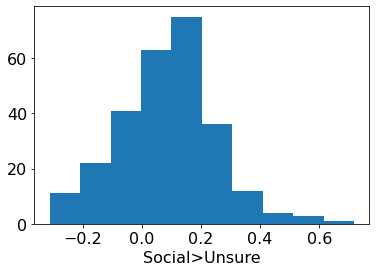

In [15]:
plt.hist(coef_soc_uns)
plt.xlabel('Social>Unsure')

In [16]:
# Unsure vs. Non-social
start_time =  time.time()
for n in range(268):
    if n%10 == 0:
        print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
    df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
    for m in other_movies:
        df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
        df = df.append(df_temp,ignore_index=True)
        df = df.loc[df['response'] != 1] # no v unsure
        
    df['response'] = df['response'].map({0.0: "Non-social", 9.0:  "Unsure"})
    model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
    model.fit(factors={"response":["Non-social","Unsure"]},summary = False, verbose = False)
    if n == 0:
        print(model.fit(factors={"response":["Non-social","Unsure"]}))
    #print('model 2:',model.fit())
    coef_uns_nonsoc[n] = model.coefs['Estimate'][1]
    pval_uns_nonsoc[n]= model.coefs['P-val'][1]


node 1,time=0.00 mins
Formula: coefs~response+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 3388	 Groups: {'subID': 813.0}

Log-likelihood: -4118.896 	 AIC: 8237.792

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.051  0.225
Residual               0.619  0.787

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.234   0.202    0.266  0.016   925.708  14.348  0.000  ***
response1       0.011  -0.083    0.105  0.048  3385.896   0.230  0.818     
node 11,time=0.07 mins
node 21,time=0.11 mins
node 31,time=0.17 mins
node 41,time=0.22 mins
node 51,time=0.28 mins
node 61,time=0.34 mins
node 71,time=0.39 mins
node 81,time=0.44 mins
node 91,time=0.50 mins
node 101,time=0.56 mins
node 111,time=0.62 mins
node 121,time=0.66 mins
node 131,time=0.71 mins
node 141,time=0.77 mins
node 151,time=0.82 mins
node 161,time=0.88 mins
node 171,time=0.9

(array([ 8., 16., 26., 40., 62., 42., 37., 18., 16.,  3.]),
 array([-0.26390429, -0.19600047, -0.12809664, -0.06019282,  0.007711  ,
         0.07561483,  0.14351865,  0.21142248,  0.2793263 ,  0.34723012,
         0.41513395]),
 <BarContainer object of 10 artists>)

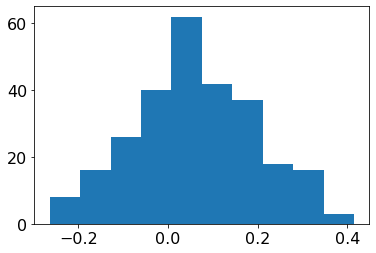

In [17]:
plt.hist(coef_uns_nonsoc)

In [18]:
# soc vs. nonsocial- - other 9 movies. sanity check for timecourse plots

start_time =  time.time()

for n in range(268):
    if n%10 == 0:
        print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
    df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
    for m in other_movies:
        df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
        df = df.append(df_temp,ignore_index=True)
        df = df.loc[df['response'] != 9] # yes v no
    
    df['response'] = df['response'].map({0.0: "Non-social", 1.0:  "Social"})
    model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
    model.fit(factors={"response":["Non-social","Social"]},summary = False, verbose = False)
    if n == 0:
        print(model.fit(factors={"response":["Non-social","Social"]}))
   
    #model.fit(summary = False, verbose = False)
    coef_soc_nonsoc[n] = model.coefs['Estimate'][1]
    pval_soc_nonsoc[n]= model.coefs['P-val'][1]

np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_soc_v_nonsoc_othermovies.npy'),coef_soc_nonsoc)


node 1,time=0.00 mins
Formula: coefs~response+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 7006	 Groups: {'subID': 814.0}

Log-likelihood: -8811.100 	 AIC: 17622.201

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.058  0.241
Residual               0.678  0.824

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.233    0.20    0.267  0.017  2238.946  13.601    0.0  ***
response1       0.159    0.12    0.198  0.020  6328.523   8.005    0.0  ***
node 11,time=0.07 mins
node 21,time=0.13 mins
node 31,time=0.19 mins
node 41,time=0.27 mins
node 51,time=0.36 mins
node 61,time=0.44 mins
node 71,time=0.51 mins
node 81,time=0.58 mins
node 91,time=0.65 mins
node 101,time=0.70 mins
node 111,time=0.78 mins
node 121,time=0.85 mins
node 131,time=0.92 mins
node 141,time=0.98 mins
node 151,time=1.06 mins
node 161,time=1.12 mins
node 171,time=1.

In [19]:
# soc vs. nonsocial - all 10 movies. sanity check for timecourse plots

'''start_time =  time.time()

for n in range(268):
    if n%10 == 0:
        print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
    df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
    for m in range(10):
        df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
        df = df.append(df_temp,ignore_index=True)
        df = df.loc[df['response'] != 9] # yes v no
    
    df['response'] = df['response'].map({0.0: "Non-social", 1.0:  "Social"})
    model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
    model.fit(factors={"response":["Non-social","Social"]},summary = False, verbose = False)
    if n == 0:
        print(model.fit(factors={"response":["Non-social","Social"]}))
   
    #model.fit(summary = False, verbose = False)
    coef_soc_nonsoc[n] = model.coefs['Estimate'][1]
    pval_soc_nonsoc[n]= model.coefs['P-val'][1]

np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_soc_v_nonsoc_allmovies.npy'),coef_soc_nonsoc)'''


'start_time =  time.time()\n\nfor n in range(268):\n    if n%10 == 0:\n        print(f\'node {n+1},time={(time.time()-start_time)/60:.2f} mins\')\n    df = pd.DataFrame(columns = [\'coefs\',\'response\',\'subID\',\'movie\'])\n    for m in range(10):\n        df_temp = pd.DataFrame({\'coefs\': all_coefs[subs_10resp,n,m],\'response\':responses[subs_10resp,m], \'subID\':subs_10resp, \'movie\':np.repeat(m,len(subs_10resp))})\n        df = df.append(df_temp,ignore_index=True)\n        df = df.loc[df[\'response\'] != 9] # yes v no\n    \n    df[\'response\'] = df[\'response\'].map({0.0: "Non-social", 1.0:  "Social"})\n    model = Lmer(\'coefs ~  response +(1|subID)\', data=df) # ff: mean response, rf:subjID\n    model.fit(factors={"response":["Non-social","Social"]},summary = False, verbose = False)\n    if n == 0:\n        print(model.fit(factors={"response":["Non-social","Social"]}))\n   \n    #model.fit(summary = False, verbose = False)\n    coef_soc_nonsoc[n] = model.coefs[\'Estimate\'][

In [20]:
# FDR-correct s>unsure and unsure >ns

pval_soc_uns_corr = lsu(pval_soc_uns,q=.05)
pval_uns_nonsoc_corr = lsu(pval_uns_nonsoc,q=.05)
#pval_soc_nonsoc = lsu(pval_soc_nonsoc,q=.05)
pval_soc_uns_unc  = pval_soc_uns <.05
pval_uns_nonsoc_unc  = pval_uns_nonsoc <.05


In [21]:
nodes_all_SUNS_UNSNS_unc = (pval_soc_uns_unc) & (pval_uns_nonsoc_unc) & (np.sign(coef_soc_uns) == np.sign(coef_uns_nonsoc))
len(np.where(nodes_all_SUNS_UNSNS_unc)[0])

64

In [22]:
# social>unsure and unsure>non-social or vice-versa
nodes_all_SUNS_UNSNS = (pval_soc_uns_corr) & (pval_uns_nonsoc_corr) & (np.sign(coef_soc_uns) == np.sign(coef_uns_nonsoc)) 
len(np.where(nodes_all_SUNS_UNSNS)[0])

59

In [23]:
# nodes common to RANDOM MECH and ALL OTHER MOVIES
#common_nodes_soc_uns_nonsoc = [65,66,68,80,150]
#common_nodes_soc_uns_nonsoc
common_nodes_soc_uns_nonsoc =  nodes_rand_SUNS_UNSNS_unc & nodes_all_SUNS_UNSNS
np.where(common_nodes_soc_uns_nonsoc)



(array([ 65,  66,  68,  80, 150]),)

In [24]:
shen268_lbl = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268_lbl.head()

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
0,"{'coords': [14.083200000000005, 56.6944, -16.6...","{'coords': [9.599999999999994, 17.618823529411...","{'coords': [5.270633397312864, 35.032629558541...","{'coords': [15.647840531561457, 34.18604651162...","{'coords': [8.283887468030684, 46.058823529411...","{'coords': [14.581460674157299, 64.75280898876...","{'coords': [30.41914191419142, 54.795379537953...","{'coords': [44.469325153374236, 46.09509202453...","{'coords': [28.814814814814817, 51.16316316316...","{'coords': [8.521081081081078, 53.28, 23.88540...",...,"{'coords': [-10.399527186761233, 10.8770685579...","{'coords': [-14.491582491582491, -3.5488215488...","{'coords': [-24.77079107505071, 5.537525354969...","{'coords': [-9.427230046948353, -25.5399061032...","{'coords': [-4.68474576271187, -10.24067796610...","{'coords': [-11.407792207792212, -25.563636363...","{'coords': [-4.821052631578951, -21.5115789473...","{'coords': [-4.227272727272734, -37.8977272727...","{'coords': [-6.9375, -33.13068181818181, -39.3...","{'coords': [-5.697885196374628, -18.9667673716..."


In [25]:
rois = [eval(shen268_lbl[str(n+1)][0])['name'] for n in np.where(common_nodes_soc_uns_nonsoc)[0]]
for i,roi in enumerate(rois):
    print(np.where(common_nodes_soc_uns_nonsoc)[0][i],roi)
print(f'\n\n{len(rois)} ROIs sig. at p-value threshold .05\n')

65 35.14% Inferior_Temporal_Gyrus_temporooccipital_part; 29.73% Lateral_Occipital_Cortex_inferior_division; 27.48% Temporal_Occipital_Fusiform_Cortex; 7.66% Occipital_Fusiform_Gyrus
66 54.07% Occipital_Fusiform_Gyrus; 28.60% Lateral_Occipital_Cortex_inferior_division; 14.90% Temporal_Occipital_Fusiform_Cortex
68 48.69% Middle_Temporal_Gyrus_temporooccipital_part; 29.07% Lateral_Occipital_Cortex_inferior_division; 22.09% Inferior_Temporal_Gyrus_temporooccipital_part
80 55.16% Occipital_Pole; 38.06% Lateral_Occipital_Cortex_inferior_division; 6.78% Occipital_Fusiform_Gyrus
150 51.03% Frontal_Orbital_Cortex; 25.77% Inferior_Frontal_Gyrus_pars_triangularis; 11.73% Frontal_Pole; 8.38% Frontal_Operculum_Cortex


5 ROIs sig. at p-value threshold .05



## Plot timecourses

In [26]:
# get the right red/blue shades
#red_rgb = [103,0,31] # edges of RdBu
#blue_rgb = [5,48,97] # edges of RdBu
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255

alpha = .2 # transparency inside boxplots, for datapts etc.

In [27]:
green_rgb = np.nanmean(np.array([red_rgb,blue_rgb]),axis=0)
green_rgb

array([0.4745098 , 0.35882353, 0.46862745])

In [28]:
TR=.72
tr0_ind = 3

In [29]:
tr0_ind = 3 # ind at which tr=0 starts
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
print(vid_start_rel_tr)
l_task = 28

def remove_pretrial_TRs(tcs,vid_start_rel_tr,pretrial_TRs):

    tcs1 = np.empty((tcs.shape[0],tcs.shape[1],28+pretrial_TRs,tcs.shape[3]))
    tcs1[:] = np.nan

    for vid_no in range(10):
        tr0 = vid_start_rel_tr[vid_no]
        tcs1[:,:,:,vid_no] = tcs[:,:,tr0-pretrial_TRs:tr0+28,vid_no] # 31 timepts
    return tcs1
    

#select subs who responded "social" to the yes movie and nonsocial to the no movie

print('\nrun-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_run_norm','timecourse-all-movies_zscorenorm.npy') # load fmri data
tcs_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_run_z.shape)
tcs_run_z = remove_pretrial_TRs(tcs_run_z,vid_start_rel_tr,tr0_ind)
print('after:',tcs_run_z.shape)


# collapse across movies and runs (for timecourse plots)

tcs_run_resh_yes = []
tcs_run_resh_no = []
tcs_run_resh_unsure = []
subs_resh_yes = []
subs_resh_no = []
subs_resh_unsure = []
for m in range(0,10):
    tcs_run_resh_yes.append(tcs_run_z[responses[:,m]==1,:,:,m])# subsm * 268 * 31
    tcs_run_resh_no.append(tcs_run_z[responses[:,m]==0,:,:,m])# subsm * 268 * 31
    tcs_run_resh_unsure.append(tcs_run_z[responses[:,m]==9,:,:,m])# subsm * 268 * 31
    subs_resh_yes += list(np.where(responses[:,m]==1)[0])# subsm * 268 * 31, keep track of subject seq
    subs_resh_no  += list(np.where(responses[:,m]==0)[0])# subsm * 268 * 31
    subs_resh_unsure  += list(np.where(responses[:,m]==9)[0])# subsm * 268 * 31
tcs_run_resh_yes = np.concatenate(tcs_run_resh_yes,axis=0)
tcs_run_resh_no  = np.concatenate(tcs_run_resh_no,axis=0)
tcs_run_resh_unsure  = np.concatenate(tcs_run_resh_unsure,axis=0)
print('Across all movies: \nyes:'+ str(tcs_run_resh_yes.shape) + ',\nno:' + str(tcs_run_resh_no.shape) + ',\nunsure:' + str(tcs_run_resh_unsure.shape))

#np.concatenate((movieTC_yes,movieTC_no),axis=0).shape

[7 14 14 14 14 7 14 14 14 14]

run-wise norm data.
before: (1048, 268, 56, 10)
after: (1048, 268, 31, 10)
Across all movies: 
yes:(4905, 268, 31),
no:(4294, 268, 31),
unsure:(636, 268, 31)


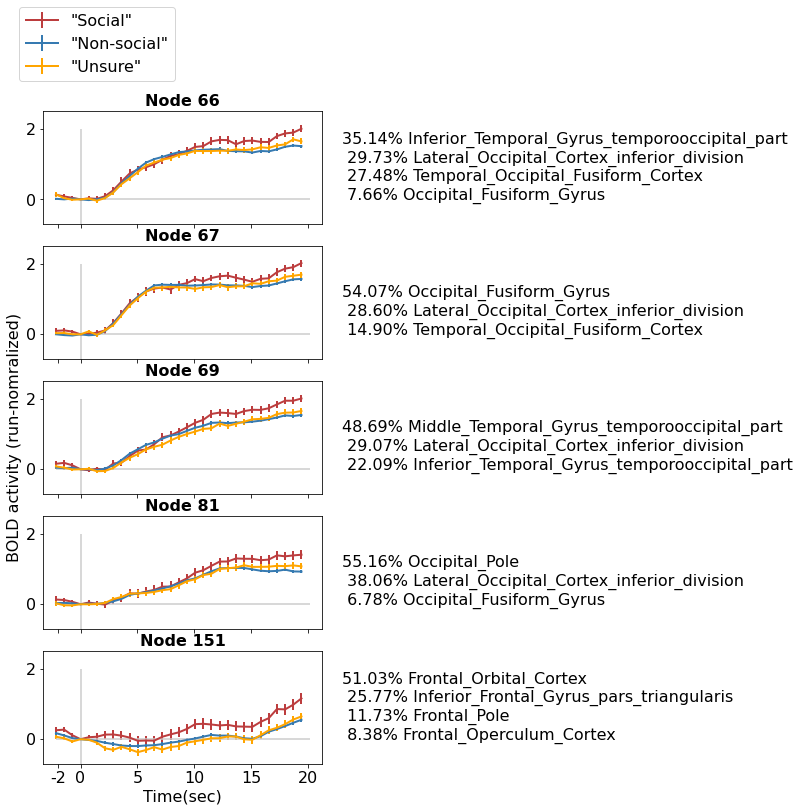

In [65]:
# plot timecourses of common nodes

[ymin,ymax] = [-.7,2.5]
xlbls = [-2,0,5,10,15,20]
x_ticks = [(i/TR)+tr0_ind for i in xlbls]
xlbls = [str(i) for i in xlbls]
nrows,ncols = 5,1
#line_loc = []
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex=True, sharey=True, figsize = (5,12)) # figsize = (20,15))
#plt.suptitle('Left hemisphere', fontweight='bold')  

if common_nodes_soc_uns_nonsoc[0] in [True,False]:
     nodes_ind = np.where(common_nodes_soc_uns_nonsoc)[0]
else:
     nodes_ind =  common_nodes_soc_uns_nonsoc
for i,n in enumerate(nodes_ind): #for i,n in enumerate(df['Nodes']):
     #fig, ax = plt.figure(i+1,figsize=(10,5))   
     
     if ncols == 1:
          ax1 = ax[i]
     else:
          r = int(np.floor(i/ncols))
          c = int(i % ncols)
          ax1 = ax[r,c]

     movieTC_yes = tcs_run_z[responses[:,4]==1,n,:,4] # nsubs * ntimepts
     movieTC_no  = tcs_run_z[responses[:,4]==0,n,:,4] # nsubs * ntimepts
     movieTC_unsure  = tcs_run_z[responses[:,4]==9,n,:,4] # nsubs * ntimepts
     
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_yes,axis=0),stats.sem(movieTC_yes,axis=0,nan_policy='omit'),color = red_rgb,linewidth=2,label ='"Social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_no,axis=0),stats.sem(movieTC_no,axis=0,nan_policy='omit'),color = blue_rgb,linewidth=2,label ='"Non-social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_unsure,axis=0),stats.sem(movieTC_unsure,axis=0,nan_policy='omit'),color = 'orange',linewidth=2,label ='"Unsure"')
     ax1.vlines(tr0_ind,-1,2,color=[.8,.8,.8])
     ax1.hlines(0,0,31,color=[.8,.8,.8])
     ax1.set_ylim(ymin,ymax)
     ax1.set_title(f'Node {n+1}',fontweight = 'bold')
     ax1.set_xticks(x_ticks)
     ax1.set_xticklabels(xlbls)
     #ax[r,0].set_ylabel('BOLD\n(a.u.)')
     txt = '\n'.join(eval(shen268_lbl[str(n+1)][0])['name'].split(';'))
     ax1.text(35,0,txt)
     if i ==2:
          ax1.set_ylabel('BOLD activity (run-nomralized)')
     if i ==4:
          ax1.set_xlabel('Time(sec)')
     if i ==0:
          ax1.legend(bbox_to_anchor = [0.5,2])

if ncols > 1:
     for i in range(int(nrows*ncols-len(np.where(predec_nodes)[0]))):
          ax[r,c+1+i].axis('off')
#plt.tight_layout()

## Save ROIs

In [30]:
fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/')

#import plotting functions

cols = ['k','k','g']
lw = [3,2,1]

lbl = [str.upper(x[0:4]) for x in vidnames]
lbl


['COAX',
 'BILL',
 'DRIF',
 'FISH',
 'RAND',
 'SCAR',
 'SEDU',
 'STAR',
 'SURP',
 'TENN']

In [31]:
from nilearn.surface import vol_to_surf
from nilearn.plotting import plot_glass_brain, plot_surf_roi,plot_stat_map,plot_img,plot_surf_contours
import nibabel as nib
from nilearn import datasets
bg_img = datasets.load_mni152_template()


from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()

from nilearn import datasets
bg_img = datasets.load_mni152_template()

from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain


mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)


def color_rois(values):
    
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    shen268 = nib.load(os.path.join(data_file_loc,"shen_2mm_268_parcellation.nii.gz"))
    shen268_data = shen268.get_fdata()
    img = np.zeros(shen268_data.shape)
    #print(shen268_data.shape)
    for roi in range(len(values)):
        itemindex = np.where(shen268_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        #print(len(itemindex[0]))
        img[itemindex] = values[roi] # color them by the desired value 

    affine = shen268.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii

In [44]:
fig_save_loc

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/'

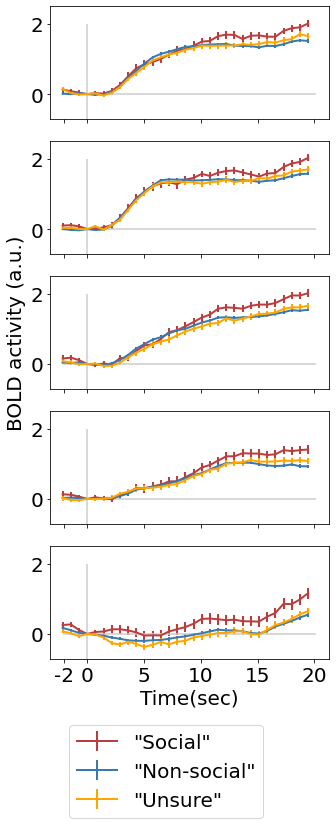

In [53]:
# plot timecourses of common nodes

[ymin,ymax] = [-.7,2.5]
xlbls = [-2,0,5,10,15,20]
x_ticks = [(i/TR)+tr0_ind for i in xlbls]
xlbls = [str(i) for i in xlbls]
nrows,ncols = 5,1
#line_loc = []
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex=True, sharey=True, figsize = (5,12)) # figsize = (20,15))
#plt.suptitle('Left hemisphere', fontweight='bold')  

if common_nodes_soc_uns_nonsoc[0] in [True,False]:
     nodes_ind = np.where(common_nodes_soc_uns_nonsoc)[0]
else:
     nodes_ind =  common_nodes_soc_uns_nonsoc
for i,n in enumerate(nodes_ind): #for i,n in enumerate(df['Nodes']):
     #fig, ax = plt.figure(i+1,figsize=(10,5))   
     
     if ncols == 1:
          ax1 = ax[i]
     else:
          r = int(np.floor(i/ncols))
          c = int(i % ncols)
          ax1 = ax[r,c]

     movieTC_yes = tcs_run_z[responses[:,4]==1,n,:,4] # nsubs * ntimepts
     movieTC_no  = tcs_run_z[responses[:,4]==0,n,:,4] # nsubs * ntimepts
     movieTC_unsure  = tcs_run_z[responses[:,4]==9,n,:,4] # nsubs * ntimepts
     
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_yes,axis=0),stats.sem(movieTC_yes,axis=0,nan_policy='omit'),color = red_rgb,linewidth=2,label ='"Social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_no,axis=0),stats.sem(movieTC_no,axis=0,nan_policy='omit'),color = blue_rgb,linewidth=2,label ='"Non-social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_unsure,axis=0),stats.sem(movieTC_unsure,axis=0,nan_policy='omit'),color = 'orange',linewidth=2,label ='"Unsure"')
     ax1.vlines(tr0_ind,-1,2,color=[.8,.8,.8])
     ax1.hlines(0,0,31,color=[.8,.8,.8])
     ax1.set_ylim(ymin,ymax)
     #ax1.set_title(f'Node {n+1}',fontweight = 'bold')
     ax1.set_xticks(x_ticks)
     ax1.set_xticklabels(xlbls)
     #ax[r,0].set_ylabel('BOLD\n(a.u.)')
     #txt = '\n'.join(eval(shen268_lbl[str(n+1)][0])['name'].split(';'))
     #ax1.text(35,0,txt)
     if i ==2:
          ax1.set_ylabel('BOLD activity (a.u.)')
     if i ==4:
          ax1.set_xlabel('Time(sec)')
     if i ==4:
          ax1.legend(bbox_to_anchor = [.8,-.5])

if ncols > 1:
     for i in range(int(nrows*ncols-len(np.where(predec_nodes)[0]))):
          ax[r,c+1+i].axis('off')
#plt.tight_layout()

plt.savefig(os.path.join(fig_save_loc,f'common_nodes/social_unsure_nonsocial/all_ROIs_tc.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')


In [33]:
nodes_ind

array([ 65,  66,  68,  80, 150])

In [72]:
# save axial plots of each roi
fig = plt.figure(1,figsize = (3,10))

if common_nodes_soc_uns_nonsoc[0] in [True,False]:
     nodes_ind = np.where(common_nodes_soc_uns_nonsoc)[0]
else:
     nodes_ind =  common_nodes_soc_uns_nonsoc
nrows = len(nodes_ind)
for i,n in enumerate(nodes_ind): #for i,n in enumerate(df['Nodes']):

    ax = fig.add_subplot(nrows,1,i+1)
    nodes = np.zeros((268,))
    nodes[n] = 1

    img = roi_to_brain(pd.Series(nodes), mask_x)
    '''zsl = row[1]['MNIz']
    if np.abs(zsl-zslices[0]) < np.abs(zsl-zslices[1]):
        zsl = zslices[0]
    else:
        zsl = zslices[1]'''
    MNIz = eval(shen268_lbl[str(n+1)][0])['coords'][2]
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',cut_coords =[MNIz],cmap = 'plasma',bg_img = bg_img,colorbar= False, threshold = .1,vmin = np.log(.72),vmax=np.log(20),axes =ax,figure=fig,annotate=False) # cmap = 'plasma'
    ax_plot.add_contours(color_rois((nodes)),linewidths=1, colors=['k'],linestyles='solid')
    ax_plot.title(f'z={MNIz:.1f}',bgcolor='w',color='k')
    #ymin,ymax = plt.ylim()
    #plt.ylim(ymin,10)
    #xmin,xmax = plt.xlim()
    #plt.xlim(xmin,10)

plt.savefig(os.path.join(fig_save_loc,f'common_nodes/social_unsure_nonsocial/all_ROIs.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
plt.clf()


<Figure size 216x720 with 0 Axes>

# Plot brainmaps

## (1) RAND MECH

In [34]:
fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/')
#coords = [np.round(eval(shen268_lbl[str(n+1)][0])['coords'][2]) for n in np.where(common_nodes_soc_uns_nonsoc)[0]]
#coords
comp_lbls = ['Soc_Unsure','Unsure_Nonsoc']

In [40]:
comp_lbls

['Soc_Unsure', 'Unsure_Nonsoc']

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


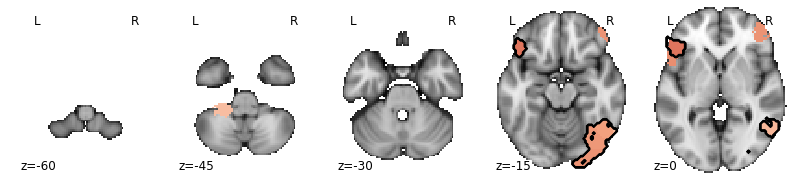

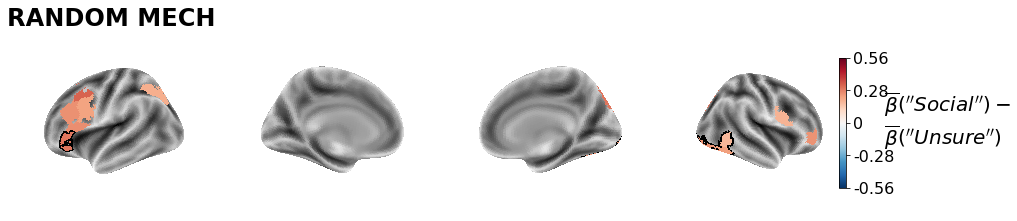

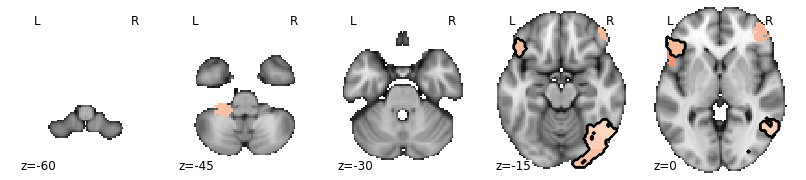

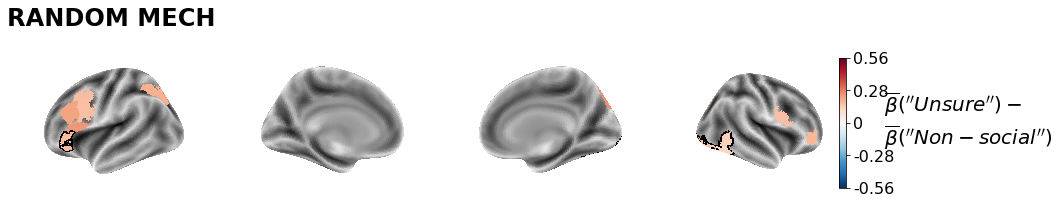

In [41]:
# surface plots
vmin,vmax = -.56,.56
cmap = 'RdBu_r'
#txt = r' $\overline{\beta}(\""")-$' + '\n' + r'$\overline{\beta}_{Non-social}$'+ '\n'
title_txt = 'RANDOM MECH'

for comp in range(2):

    nodes = np.zeros((268,))
    if comp == 0:
        txt = '  'r"$\overline{\beta}{(''Social'')}-$" + '\n  ' + r"$\overline{\beta}{(''Unsure'')}$"
        nodes[nodes_rand_SUNS_UNSNS_unc] = meanDiff_sl_rand_S_UNS[nodes_rand_SUNS_UNSNS_unc]
    else:
        txt = '  'r"$\overline{\beta}{(''Unsure'')}-$" + '\n  ' + r"$\overline{\beta}{(''Non-social'')}$"
        nodes[nodes_rand_SUNS_UNSNS_unc] = meanDiff_sl_rand_UNS_NS[nodes_rand_SUNS_UNSNS_unc]
    
    img = roi_to_brain(pd.Series(nodes), mask_x)
    #coords = [-50,-40,-30,-20,-10,0,10,25,40,50,60] # initial exploration
    coords = [-60,-45,-30,-15,0] # initial exploration
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
    #ax_plot.title(title_txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
    #ax_plot._colorbar_ax.text(1,.8*vmax,txt,fontsize=20,fontdict = {'verticalalignment':'top','rotation':0})#get_legend()
    ax_plot.add_contours(color_rois(common_nodes_soc_uns_nonsoc),linewidths=1, colors=['k'],linestyles ='-',filled=False)
    plt.savefig(os.path.join(fig_save_loc,f'RAND/{comp_lbls[comp]}_axial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    #plt.clf()

    fig,ax = plt.subplots(nrows=1, ncols= 4,figsize=(15,4),subplot_kw={'projection': '3d'})
    
    #LH
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left,axes=ax[0])#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    #surf_plot1.axes[1].text(4,.8*vmax,s= txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    surf_plot1.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
    texture_contour = vol_to_surf(color_rois(common_nodes_soc_uns_nonsoc), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture_contour,axes=ax[0], figure=surf_plot1, legend=True,levels = [1], colors=['k'])
    #plt.savefig(os.path.join(fig_save_loc,f'RAND/{comp_lbls[comp]}_surf_left_lat.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    #plt.clf()

    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes=ax[1])#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    #surf_plot2.axes[1].text(4,.8*vmax,s= txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    #surf_plot2.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
    plot_surf_contours(fsaverage.infl_left, texture_contour, figure=surf_plot2, axes=ax[1],legend=True,levels = [1], colors=['k'])
    #plt.savefig(os.path.join(fig_save_loc,f'RAND/{comp_lbls[comp]}_surf_left_med.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    #plt.clf()
    
    #RH
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right,axes=ax[3])#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    #surf_plot3.axes[1].text(4,.8*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    #surf_plot3.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
    texture_contour = vol_to_surf(color_rois(common_nodes_soc_uns_nonsoc), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture_contour, figure=surf_plot3, axes=ax[3],legend=True,levels = [1], colors=['k'])
    surf_plot3.axes[4].text(5,.5*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    #plt.savefig(os.path.join(fig_save_loc,f'RAND/{comp_lbls[comp]}_surf_right_lat.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    #plt.clf()

    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right, view ='medial',axes=ax[2])#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    #surf_plot4.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
    plot_surf_contours(fsaverage.infl_right, texture_contour, figure=surf_plot4, legend=True, levels = [1], colors=['k'],axes=ax[2])#, labels=['Sig. (q<.05) across\n(a),(c),(d)'])
    #plt.savefig(os.path.join(fig_save_loc,f'RAND/{comp_lbls[comp]}_surf_right_med.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    #plt.clf()
    plt.savefig(os.path.join(fig_save_loc,f'RAND/surf_all4_{comp_lbls[comp]}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    

In [79]:
print(min(meanDiff_sl_rand_S_UNS),max(meanDiff_sl_rand_S_UNS))
print(min(meanDiff_sl_rand_UNS_NS),max(meanDiff_sl_rand_UNS_NS))

-0.1513095294974113 0.42701490941385956
-0.268091808634905 0.25409751320748264


## (2) ALL MOVIES

In [39]:
title_txt = 'ALL OTHER MOVIES'
print('All movies: S v Unsure:',min(coef_soc_uns),max(coef_soc_uns))
print('All movies: Unsure v BS:',min(coef_uns_nonsoc),max(coef_uns_nonsoc))


All movies: S v Unsure: -0.3125126449161747 0.7177950067548614
All movies: Unsure v BS: -0.26390429104281937 0.4151339469265551


/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


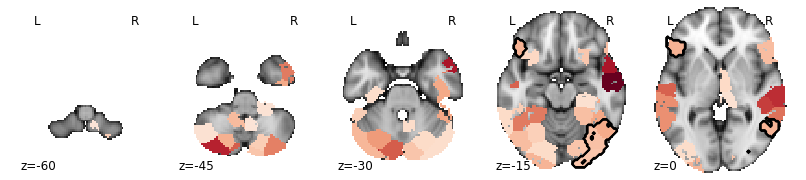

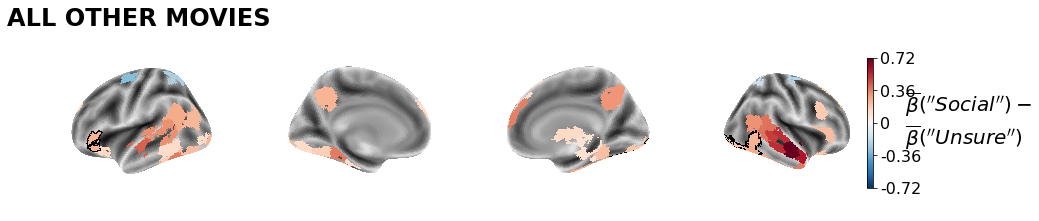

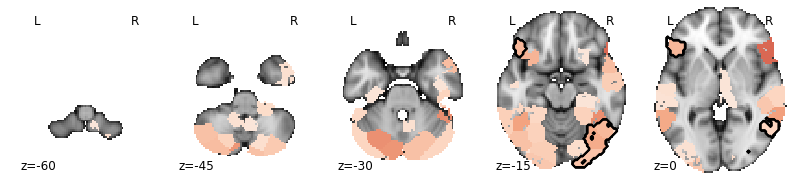

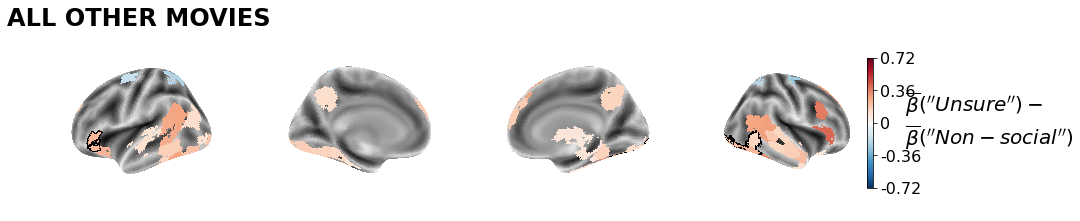

In [42]:
# surface plots
vmin,vmax = -.72,.72
cmap = 'RdBu_r'
#txt = r' $\overline{\beta}(\""")-$' + '\n' + r'$\overline{\beta}_{Non-social}$'+ '\n'
title_txt = 'ALL OTHER MOVIES'

for comp in range(2):
    
    nodes = np.zeros((268,))
    if comp == 0:    
        txt = '  'r"$\overline{\beta}{(''Social'')}-$" + '\n  ' + r"$\overline{\beta}{(''Unsure'')}$"
        nodes[nodes_all_SUNS_UNSNS_unc] = coef_soc_uns[nodes_all_SUNS_UNSNS_unc] # nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)

    else:
        txt = '  'r"$\overline{\beta}{(''Unsure'')}-$" + '\n  ' + r"$\overline{\beta}{(''Non-social'')}$"
        nodes[nodes_all_SUNS_UNSNS_unc] = coef_uns_nonsoc[nodes_all_SUNS_UNSNS_unc]# nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)

    
    img = roi_to_brain(pd.Series(nodes), mask_x)
    #coords = [-50,-40,-30,-20,-10,0,10,25,40,50,60] # initial exploration
    coords = [-60,-45,-30,-15,0] # initial exploration
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
    #ax_plot.title(title_txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
    #ax_plot._colorbar_ax.text(1,.8*vmax,txt,fontsize=20,fontdict = {'verticalalignment':'top','rotation':0})#get_legend()
    ax_plot.add_contours(color_rois(common_nodes_soc_uns_nonsoc),linewidths=1, colors=['k'],linestyles ='-',filled=False)
    plt.savefig(os.path.join(fig_save_loc,f'ALL_OTHERS/{comp_lbls[comp]}_axial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    #plt.clf()

    fig,ax = plt.subplots(nrows=1, ncols= 4,figsize=(15,4),subplot_kw={'projection': '3d'})
    

    #LH
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left,axes=ax[0])#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    #surf_plot1.axes[1].text(4,.8*vmax,s= txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    surf_plot1.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
    texture_contour = vol_to_surf(color_rois(common_nodes_soc_uns_nonsoc), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture_contour, figure=surf_plot1,axes=ax[0], legend=True,levels = [1], colors=['k'])
    #plt.savefig(os.path.join(fig_save_loc,f'ALL_OTHERS/{comp_lbls[comp]}_surf_left_lat.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    #plt.clf()

    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes=ax[1])#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    #surf_plot2.axes[1].text(4,.8*vmax,s= txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    #surf_plot2.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
    plot_surf_contours(fsaverage.infl_left, texture_contour,axes=ax[1], figure=surf_plot2, legend=True,levels = [1], colors=['k'])
    #plt.savefig(os.path.join(fig_save_loc,f'ALL_OTHERS/{comp_lbls[comp]}_surf_left_med.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    #plt.clf()

    #RH
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right,axes=ax[3])#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    #surf_plot3.axes[1].text(4,.8*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    #surf_plot3.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
    texture_contour = vol_to_surf(color_rois(common_nodes_soc_uns_nonsoc), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture_contour,axes=ax[3], figure=surf_plot3, legend=True,levels = [1], colors=['k'])
    surf_plot3.axes[4].text(5,.5*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    #plt.savefig(os.path.join(fig_save_loc,f'ALL_OTHERS/{comp_lbls[comp]}_surf_right_lat.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    #plt.clf()

    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap,axes=ax[2], colorbar=False,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right, view ='medial')#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    #surf_plot4.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
    plot_surf_contours(fsaverage.infl_right, texture_contour, figure=surf_plot4,axes=ax[2], legend=True, levels = [1], colors=['k'])#, labels=['Sig. (q<.05) across\n(a),(c),(d)'])
    #plt.savefig(os.path.join(fig_save_loc,f'ALL_OTHERS/{comp_lbls[comp]}_surf_right_med.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    #plt.clf()

    #plt.savefig(os.path.join(fig_save_loc,f'ALL_OTHERS/{comp_lbls[comp]}_surf_right_med.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    plt.savefig(os.path.join(fig_save_loc,f'ALL_OTHERS/surf_all4_{comp_lbls[comp]}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    


In [63]:
# glassplots
'''vmin,vmax =-.3,.68

fig=plt.figure(1,figsize=((10,3)))
txt = r"$\overline{\beta}(''Social'')-$" + '\n' + r"$\overline{\beta}(''Unsure'')$"
nodes = np.zeros((268,))
nodes[nodes_all_SUNS_UNSNS] = coef_soc_uns[nodes_all_SUNS_UNSNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
#img = roi_to_brain(pd.Series(coef_soc_uns), mask_x)
glassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = True, title='ALL MOVIES', alpha=0.7, vmin=vmin,vmax= vmax, 
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb.title(title_txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.1,txt,fontsize=20,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb.add_contours(color_rois(nodes_all_SUNS_UNSNS),linewidths=lw[0], colors=[cols[0]],linestyles='dotted')
glassb.add_contours(color_rois(common_nodes_soc_uns_nonsoc),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'all_movies/social_v_unsure.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

nodes = np.zeros((268,))
nodes[common_nodes_soc_uns_nonsoc] = coef_soc_uns[common_nodes_soc_uns_nonsoc]
img = roi_to_brain(pd.Series(nodes), mask_x)
#plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
#                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
ax_plot = plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=coords, cmap = 'RdBu_r',vmax=vmax,colorbar=False,annotate=True)
#ax_plot.title("ALL MOVIES",fontsize=24,bgcolor='k',color='w',fontweight='bold')
plt.savefig(os.path.join(fig_save_loc,'all_movies/social_v_unsure_axial.png'),dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')'''


# glass plots
'''fig=plt.figure(1,figsize=((10,3)))
txt = r"$\overline{\beta}(''Unsure'')-$" + '\n' + r"$\overline{\beta}(''Non-social'')$"
nodes = np.zeros((268,))
nodes[nodes_all_SUNS_UNSNS] = coef_uns_nonsoc[nodes_all_SUNS_UNSNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
#img = roi_to_brain(pd.Series(coef_uns_nonsoc), mask_x)
glassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = True, title='ALL MOVIES', alpha=0.7, vmin=vmin,vmax= vmax, 
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb.title(title_txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.1,txt,fontsize=20,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb.add_contours(color_rois(nodes_all_SUNS_UNSNS),linewidths=lw[0], colors=[cols[0]],linestyles='dotted')
glassb.add_contours(color_rois(common_nodes_soc_uns_nonsoc),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'all_movies/unsure_v_nonsocial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

nodes = np.zeros((268,))
nodes[common_nodes_soc_uns_nonsoc] = coef_uns_nonsoc[common_nodes_soc_uns_nonsoc]
img = roi_to_brain(pd.Series(nodes), mask_x)
#plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
#                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
ax_plot = plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=coords, cmap = 'RdBu_r',vmax=vmax,colorbar=False,annotate=True)
#ax_plot.title("ALL MOVIES",fontsize=24,bgcolor='k',color='w',fontweight='bold')
plt.savefig(os.path.join(fig_save_loc,'all_movies/unsure_v_nonsocial_axial.png'),dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')'''



'vmin,vmax =-.3,.68\n\nfig=plt.figure(1,figsize=((10,3)))\ntxt = r"$\\overline{\x08eta}(\'\'Social\'\')-$" + \'\n\' + r"$\\overline{\x08eta}(\'\'Unsure\'\')$"\nnodes = np.zeros((268,))\nnodes[nodes_all_SUNS_UNSNS] = coef_soc_uns[nodes_all_SUNS_UNSNS]\nimg = roi_to_brain(pd.Series(nodes), mask_x)\n#img = roi_to_brain(pd.Series(coef_soc_uns), mask_x)\nglassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = True, title=\'ALL MOVIES\', alpha=0.7, vmin=vmin,vmax= vmax, \n                display_mode=\'lyrz\', plot_abs=False, black_bg=False,cmap = \'RdBu_r\',colorbar = True)\nglassb.title(title_txt,fontsize=24,bgcolor=\'k\',color=\'w\',fontweight=\'bold\')\nglassb._colorbar_ax.text(0.9,0.1,txt,fontsize=20,fontdict = {\'verticalalignment\':\'center\',\'rotation\':0})#get_legend()\n#glassb.add_contours(color_rois(nodes_all_SUNS_UNSNS),linewidths=lw[0], colors=[cols[0]],linestyles=\'dotted\')\nglassb.add_contours(color_rois(common_nodes_soc_uns_nonsoc),linewidths=lw[0], colors=[cols[0]],lines

## Correlation plots

In [83]:
# correlation plots

def plot_fig(X,Y,xlabel,ylabel,xymin,xymax):
    plt.plot(X,Y,ls='None',marker='.',alpha = .5,color='grey',label = 'mean diff. per node',markersize=8)
    r,p = stats.pearsonr(X,Y)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
   
    plt.xlim(xymin,xymax)
    plt.ylim(xymin,xymax)

    xpos = xymin+ .05*(xymax-xymin)
    ypos = xymin+ .8*(xymax-xymin)
    plt.text(xpos,ypos,f'r={r:.2f},\np={p:.1e}',fontsize=20)

    m, b = np.polyfit(X,Y, 1)
    print(np.poly1d([m,b]))
    xplot = np.linspace(xymin,xymax,10)
    plt.plot(xplot, m*xplot + b,ls='dashed',color = 'k',label = 'line of best fit\n(all nodes)')
    
    plt.vlines(0,xymin,xymax,color = 'grey',ls = 'dashed',alpha = .4)
    plt.hlines(0,xymin,xymax,color = 'grey',ls = 'dashed',alpha = .4)
   

def plot_sig_nodes(X,Y,inds):
    plt.plot(X[inds],Y[inds],ls='None',marker='+',
    mfc='k', mec='k',mew = 3, linewidth = 5,label = 'sig. across both axes',ms=12)


 
0.09687 x + 0.009471


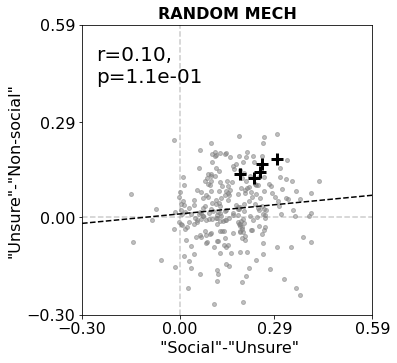

In [85]:
# CHECK THIS CELL AGAIN BEFORE RUNNING NEXT!!!!!!!

dims = [12,9.6]
fig= plt.figure(1,figsize = dims)

xymin,xymax = -.3,.59
    
#plt.suptitle('Mean differences: "Social" - "Nonsocial"',fontweight='bold')
ax = fig.add_subplot(221)
X,Y = meanDiff_sl_rand_S_UNS,meanDiff_sl_rand_UNS_NS
plot_fig(X,Y,' "Social"-"Unsure"', '"Unsure"-"Non-social"',xymin,xymax)
ax.set_aspect('equal')
#signodes
plot_sig_nodes(X,Y,common_nodes_soc_uns_nonsoc)
#plt.plot(X[nodes_rand_SUNS_UNSNS_unc],Y[nodes_rand_SUNS_UNSNS_unc],mec='k',marker='o',mfc='none',ls='None')
#plt.title('RANDOM MECH')
#plt.legend(bbox_to_anchor = (1,1),fontsize =16)
plt.title('RANDOM MECH',fontweight='bold')

plt.xticks([np.round(i,2) for i in np.linspace(xymin*10,xymax*10,4)/10])
plt.yticks([np.round(i,2) for i in np.linspace(xymin*10,xymax*10,4)/10])

plt.tight_layout()

plt.savefig(os.path.join(fig_save_loc,'RAND/rand_soc_v_unsure_v_nonsoc_scatterplots.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')


## All movies, plot scatterplot and brainmaps : S > Unsure > NS

 
0.1279 x + 0.05142


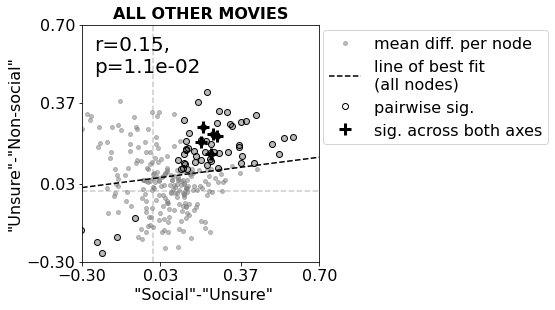

In [86]:
# scatterplot
dims = [12,9.6]
fig= plt.figure(1,figsize = dims)

xymin,xymax = -.3,.7
#plt.suptitle('Mean differences: "Social" - "Nonsocial"',fontweight='bold')
ax = fig.add_subplot(221)
X,Y = coef_soc_uns,coef_uns_nonsoc
plot_fig(X,Y,' "Social"-"Unsure"','"Unsure"-"Non-social"',xymin,xymax)
ax.set_aspect('equal')
#signodes
plt.plot(X[nodes_all_SUNS_UNSNS],Y[nodes_all_SUNS_UNSNS],mec='k',marker='o',mfc='none',markersize=6,ls='None',label = 'pairwise sig.')
plot_sig_nodes(X,Y,common_nodes_soc_uns_nonsoc)
#plt.plot(X[nodes_all_SUNS_UNSNS],Y[nodes_all_SUNS_UNSNS],mec='k',marker='o',mfc='none',ls='None')
plt.title('ALL OTHER MOVIES',fontweight='bold')
plt.legend(bbox_to_anchor = (2,1.01),fontsize =16)
plt.xlim(xymin,xymax)
plt.ylim(xymin,xymax)
plt.xticks([np.round(i,2) for i in np.linspace(-3,7,4)/10])
plt.yticks([np.round(i,2) for i in np.linspace(-3,7,4)/10])
plt.savefig(os.path.join(fig_save_loc,'ALL_OTHERS/all_soc_v_unsure_v_nonsoc_scatterplots.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')




# Unsure > sure

### 1.  Random Mech

- Here, at first I did an Unsure > Sure, but on looking at the timecourses realized that we effectively end up seeing unsure > non-social since (social+non-social) for random mech is dominated by non-social. A better way would be to find the intersection of unsure > social and unsure > non-social, but then I see that no nodes show this intersection even at the uncorrected p-value threshold (see below).

- may be better to do this only on All movies? (Or at least RANDOM MECH + FISHING? - but need a good reason for this over "all movies")

In [88]:
# social>unsure and unsure>non-social or vice-versa, both corrected
nodes_rand_UNSS_UNSNS = (pval_slope_rand_S_UNS) & (pval_slope_rand_UNS_NS) & (meanDiff_sl_rand_S_UNS < 0) & (meanDiff_sl_rand_UNS_NS > 0)
print('nodes_rand_UNSS_UNSNS:',len(np.where(nodes_rand_UNSS_UNSNS)[0])) # no sig  ndoes for RAND

#### same as above, unc.
# social>unsure and unsure>non-social or vice-versa, both uncorrected
nodes_rand_UNSS_UNSNS_unc = (pval_slope_rand_S_UNS_unc) & (pval_slope_rand_UNS_NS_unc) & (meanDiff_sl_rand_S_UNS < 0) & (meanDiff_sl_rand_UNS_NS > 0) 
print('nodes_rand_UNSS_UNSNS_unc:',len(np.where(nodes_rand_UNSS_UNSNS_unc)[0])) # 10 sig nodes for RAND


nodes_rand_UNSS_UNSNS: 0
nodes_rand_UNSS_UNSNS_unc: 0


In [89]:
movie_ind = 4
coef_slope_rand = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','coef_slopereg_runnorm_Random mechanical.npy'))

soc_inds = responses[:,movie_ind]==1 # subs who responded "social"
nonsoc_inds = responses[:,movie_ind]==0 # subs who respoded "nonsocial"
unsure_inds = responses[:,movie_ind]==9 # subs who respoded "unsure"

_,pval_slope_rand_unsure_sure_unc = stats.ttest_ind(coef_slope_rand[unsure_inds,:],coef_slope_rand[soc_inds|nonsoc_inds,:], axis=0, equal_var=False)
pval_slope_rand_unsure_sure = lsu(pval_slope_rand_unsure_sure_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_unsure_sure = np.nanmean(coef_slope_rand[unsure_inds,:],axis=0)-np.nanmean(coef_slope_rand[soc_inds|nonsoc_inds,:],axis=0)

pval_slope_rand_unsure_sure_unc = pval_slope_rand_unsure_sure_unc<.05

print('unc.:',len(np.where(pval_slope_rand_unsure_sure_unc)[0]))
print('corr.:',len(np.where(pval_slope_rand_unsure_sure)[0]))


unc.: 37
corr.: 0


In [90]:
all_coefs = np.zeros((1048,268,10))

for m in range(10):
    fileName =  os.path.join(data_file_loc,'coefs_run_norm','slope_reg', f'coef_slopereg_runnorm_{vidnames[m]}.npy')
    
    all_coefs[:,:,m] = np.load(fileName)
    #print(dat.shape)

In [112]:
# Unsure > Sure

#movies_list_ind =  int(input('All movies (1) or all except RAND (2):'))

movies_list_ind =  1
if movies_list_ind == 1:
    movies_list = np.arange(10)
elif movies_list_ind == 2:
    movies_list = [0,1,2,3,5,6,7,8.9]
else:
    print('SOMETHING WRONG, ENTER AGAIN!!')

print('movies_list:',movies_list)
coef_unsure_sure = np.empty((268,))
coef_unsure_sure[:]  = np.nan

pval_unsure_sure = np.empty((268,))
pval_unsure_sure[:]= np.nan

start_time =  time.time()
for n in range(268):
    if n%10 == 0:
        print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
    df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
    for m in movies_list:
        df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
        df = df.append(df_temp,ignore_index=True)
    
    df['uncertainty'] = ['Uncertain' if i == 9 else 'Certain' for i in df['response'].values]
        
    model = Lmer('coefs ~  uncertainty + (1|subID)', data=df) # ff: mean response, rf:subjID
    #print('model 4:',model.fit())
    model.fit(factors={"uncertainty":["Certain","Uncertain"]},summary = False, verbose = False)
    if n == 0:
        print(model.fit(factors={"uncertainty":["Certain","Uncertain"]}))
    #model.fit(summary = False, verbose = False)
    coef_unsure_sure[n] = model.coefs['Estimate'][1]
    pval_unsure_sure[n]= model.coefs['P-val'][1]



movies_list: [0 1 2 3 4 5 6 7 8 9]
node 1,time=0.00 mins
Formula: coefs~uncertainty+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 8140	 Groups: {'subID': 814.0}

Log-likelihood: -10219.155 	 AIC: 20438.311

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.059  0.244
Residual               0.676  0.822

No random effect correlations specified

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)      0.315   0.290    0.340  0.013   868.016  24.749  0.000  ***
uncertainty1    -0.052  -0.129    0.025  0.039  8024.759  -1.326  0.185     
node 11,time=0.08 mins
node 21,time=0.16 mins
node 31,time=0.23 mins
node 41,time=0.30 mins
node 51,time=0.37 mins
node 61,time=0.44 mins
node 71,time=0.51 mins
node 81,time=0.58 mins
node 91,time=0.67 mins
node 101,time=0.76 mins
node 111,time=0.83 mins
node 121,time=0.91 mins
node 131,time=0.98 mins
node 141,time=1.05 mins
node 151,time=1.12 min

In [97]:
coef_unsure_soc_all, pval_unsure_soc_all, coef_unsure_nonsoc_all, pval_unsure_nonsoc_all = [np.empty((268,)) for  _ in range(4)]
coef_unsure_soc_all[:], pval_unsure_soc_all[:], coef_unsure_nonsoc_all[:], pval_unsure_nonsoc_all[:] = [np.nan] * 4

In [99]:
# Unsure > Soc

movies_list_ind =  1
if movies_list_ind == 1:
    print('10 movies')
    movies_list = np.arange(10)
elif movies_list_ind == 2:
    print('9 movies')
    movies_list = [0,1,2,3,5,6,7,8.9]
else:
    print('SOMETHING WRONG, ENTER AGAIN!!')
  
print('movies_list:',movies_list)

start_time =  time.time()
for n in range(268):
    if n%10 == 0:
        print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
    df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
    for m in movies_list:
        df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
        df = df.append(df_temp,ignore_index=True)
    
    #df['uncertainty'] = ['Uncertain' if i == 9 else 'Certain' for i in df['response'].values]
    
    df = df.loc[df['response']!= 0,:]
    df['response'] = df['response'].map({1.0: "Social", 9.0:  "Unsure"})
    model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
    model.fit(factors={"response":["Social","Unsure"]},summary = False, verbose = False) # Unsure > Social
    if n == 0:
        print(model.fit(factors={"response":["Social","Unsure"]}))

    coef_unsure_soc_all[n] = model.coefs['Estimate'][1]
    pval_unsure_soc_all[n]= model.coefs['P-val'][1]



10 movies
movies_list: [0 1 2 3 4 5 6 7 8 9]
node 1,time=0.00 mins
Formula: coefs~response+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 4516	 Groups: {'subID': 814.0}

Log-likelihood: -5823.547 	 AIC: 11647.094

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.091  0.302
Residual               0.699  0.836

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)      0.39   0.357    0.423  0.017   918.769  22.996  0.000  ***
response1       -0.13  -0.211   -0.049  0.041  4345.800  -3.137  0.002   **
node 11,time=0.06 mins
node 21,time=0.12 mins
node 31,time=0.18 mins
node 41,time=0.23 mins
node 51,time=0.29 mins
node 61,time=0.35 mins
node 71,time=0.40 mins
node 81,time=0.47 mins
node 91,time=0.53 mins
node 101,time=0.59 mins
node 111,time=0.66 mins
node 121,time=0.72 mins
node 131,time=0.78 mins
node 141,time=0.84 mins
node 151,time=0.89 

In [105]:
# Unsure > Nonsoc

start_time =  time.time()
for n in range(268):
    if n%10 == 0:
        print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
    df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
    for m in movies_list:
        df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
        df = df.append(df_temp,ignore_index=True)
    
    #df['uncertainty'] = ['Uncertain' if i == 9 else 'Certain' for i in df['response'].values]
    
    df = df.loc[df['response']!= 1,:]
    df['response'] = df['response'].map({0.0: "Non-social", 9.0:  "Unsure"})
    model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
    model.fit(factors={"response":["Non-social","Unsure"]},summary = False, verbose = False) # Unsure > Social
    if n == 0:
        print(model.fit(factors={"response":["Non-social","Unsure"]}))

    coef_unsure_nonsoc_all[n] = model.coefs['Estimate'][1]
    pval_unsure_nonsoc_all[n]= model.coefs['P-val'][1]


node 1,time=0.00 mins
Formula: coefs~response+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 4118	 Groups: {'subID': 814.0}

Log-likelihood: -4998.169 	 AIC: 9996.337

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.054  0.233
Residual               0.616  0.785

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.232   0.202    0.262  0.015   951.168  15.016  0.000  ***
response1       0.028  -0.049    0.104  0.039  4100.258   0.716  0.474     
node 11,time=0.06 mins
node 21,time=0.12 mins
node 31,time=0.18 mins
node 41,time=0.23 mins
node 51,time=0.28 mins
node 61,time=0.34 mins
node 71,time=0.40 mins
node 81,time=0.45 mins
node 91,time=0.51 mins
node 101,time=0.57 mins
node 111,time=0.63 mins
node 121,time=0.70 mins
node 131,time=0.76 mins
node 141,time=0.81 mins
node 151,time=0.87 mins
node 161,time=0.92 mins
node 171,time=0.9

In [106]:
pval_unsure_sure_conj = (pval_unsure_soc_all<.05) & (pval_unsure_nonsoc_all<.05)

pval_unsure_soc_all1 = lsu(pval_unsure_soc_all,q=.05)
pval_unsure_nonsoc_all1 = lsu(pval_unsure_nonsoc_all,q=.05)

pval_unsure_sure_conj_corr = pval_unsure_soc_all1 & pval_unsure_nonsoc_all1
len(np.where(pval_unsure_sure_conj_corr)[0])

98

In [213]:
pval_end = np.empty((268,2)) # unsure != s, unsure != ns
pval_end[:] = np.nan
for n in range(268):
    yes_end, no_end, unsure_end = np.nanmean(tcs_run_resh_yes[:,n,-2:],axis=1),np.nanmean(tcs_run_resh_no[:,n,-2:],axis=1), np.nanmean(tcs_run_resh_unsure[:,n,-2:],axis=1)
    if np.nanmean(unsure_end) > np.nanmean(yes_end):
        _,pval_end[n,0] = stats.ttest_ind(unsure_end,yes_end,nan_policy='omit',equal_var=False)
    if np.nanmean(unsure_end) > np.nanmean(no_end):
        _,pval_end[n,1] = stats.ttest_ind(unsure_end,no_end,nan_policy='omit',equal_var=False)

pval_end_corr = np.empty_like(pval_end)
pval_end_corr[:] = np.nan
rows = ~np.isnan(pval_end[:,0])
pval_end_corr[rows,0] = lsu(pval_end[rows,0],q=.05) #fdr_correction(pval_slope_rand,.05)
rows = ~np.isnan(pval_end[:,1])
pval_end_corr[rows,1] = lsu(pval_end[rows,1],q=.05)#fdr_correction(pval_slope_rand,.05)


In [258]:
len(np.where(pval_unsure_sure_conj_corr)[0])

98

In [229]:
#So next, let's count the nr. of Unsure > sure nodes at the fdr-corrected threshold

all_nodes_unsure_greaterthan_sure_conj = pval_unsure_sure_conj_corr & (coef_unsure_soc_all>0) & (coef_unsure_nonsoc_all>0) 
print(len(np.where(all_nodes_unsure_greaterthan_sure_conj)[0]))

all_nodes_unsure_greaterthan_sure_conj_endcrit = pval_unsure_sure_conj_corr & (coef_unsure_soc_all>0) & (coef_unsure_nonsoc_all>0) & (pval_end[:,0]<.05) & (pval_end[:,1]<.05) # & (pval_end_corr[:,0]==1) & (pval_end_corr[:,1]==1) 
print(len(np.where(all_nodes_unsure_greaterthan_sure_conj_endcrit)[0]))

#So next, let's count the nr. of Unsure > sure nodes at the fdr-corrected threshold
# this analysis didn't give the best nodes, so am doing a  conjunction analysis now (unsure > social) and (unsure > nonsocial)
'''pval_unsure_sure1 = lsu(pval_unsure_sure,q=.05)
len(np.where(pval_unsure_sure1)[0])  #nr. of nodes showing a sig. dependence of reg coeffts on uncertainty - but this could be uncertain > certain or vice-versa

all_nodes_unsure_greaterthan_sure = pval_unsure_sure1 & (coef_unsure_sure>0)
print(len(np.where(all_nodes_unsure_greaterthan_sure)[0]))'''

20
12


'pval_unsure_sure1 = lsu(pval_unsure_sure,q=.05)\nlen(np.where(pval_unsure_sure1)[0])  #nr. of nodes showing a sig. dependence of reg coeffts on uncertainty - but this could be uncertain > certain or vice-versa\n\nall_nodes_unsure_greaterthan_sure = pval_unsure_sure1 & (coef_unsure_sure>0)\nprint(len(np.where(all_nodes_unsure_greaterthan_sure)[0]))'

In [179]:
# common nodes for rand and all other movies

all_nodes_randdirn_unsure_greaterthan_sure = pval_unsure_sure1 & (coef_unsure_sure>0) & (meanDiff_sl_rand_S_UNS<0) & (meanDiff_sl_rand_UNS_NS>0)
print(np.where(all_nodes_randdirn_unsure_greaterthan_sure))

#rand_nodes_insig = (meanDiff_sl_rand_S_UNS<0) & (meanDiff_sl_rand_UNS_NS>0)
#print(np.where(rand_nodes_insig))

#rand_nodes_insig = (meanDiff_sl_rand_S_UNS<0) & (meanDiff_sl_rand_UNS_NS>0)
#np.where(rand_nodes_insig)

(array([35]),)
(array([], dtype=int64),)
(array([  1,  35,  37,  50,  96, 242]),)


In [21]:
#rand_nodes_unsure_greaterthan_sure = pval_slope_rand_unsure_sure_unc & (meanDiff_sl_rand_unsure_sure>0)
#rand_nodes_unsure_greaterthan_sure = pval_slope_rand_unsure_sure_unc & (meanDiff_sl_rand_unsure_sure>0)
#len(np.where(rand_nodes_unsure_greaterthan_sure)[0])

#common_nodes = rand_nodes_unsure_greaterthan_sure & all_nodes_unsure_greaterthan_sure
#len(np.where(common_nodes)[0])
#common_nodes = [26,34,148,153,154,175,217]

# ^^ above step has the issue mentioned at the start of this section, viz. that we'd end up seeing unsure > nonsocial nodes

In [22]:
# Better. Now let's plot all these nodes on the brain

### Plot brainmaps and scatterplots for all movies' analyses

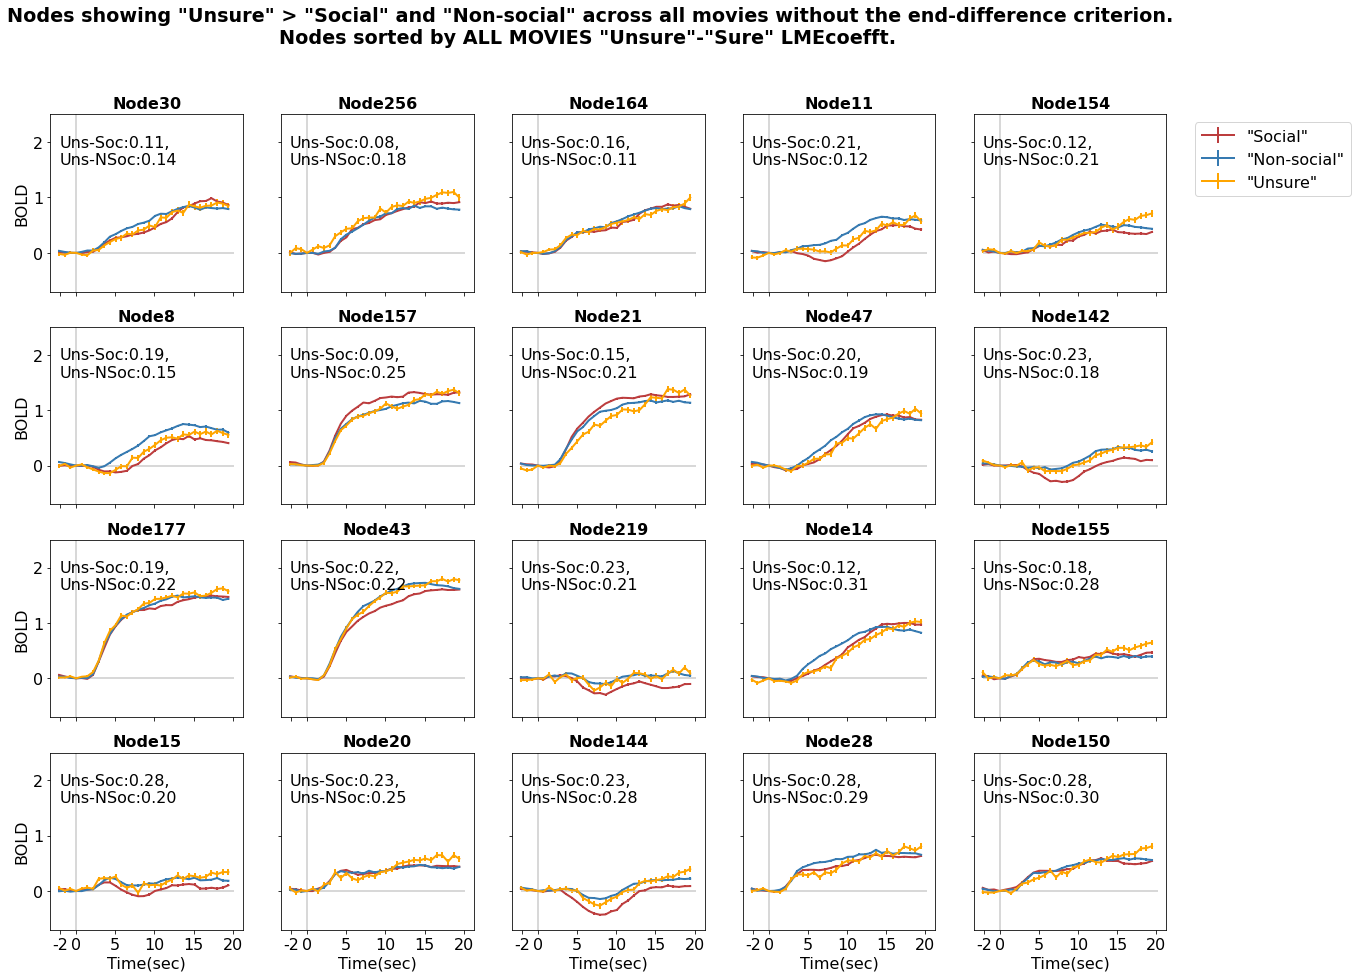

In [243]:
rand = 0 # CHANGE WHAT TO PLOT HERE!! 1: RAND, 0: ALL MOVIES

[ymin,ymax] = [-.7,2.5]
xlbls = [-2,0,5,10,15,20]
x_ticks = [(i/TR)+tr0_ind for i in xlbls]
xlbls = [str(i) for i in xlbls]

nodes = np.where(all_nodes_unsure_greaterthan_sure_conj)[0] # rand_nodes_insig)[0]
mag_avg = np.nanmean(np.array([coef_unsure_soc_all,coef_unsure_nonsoc_all]),axis=0)
nodes = nodes[np.argsort(mag_avg[nodes])]#(-coef_unsure_sure[nodes])]
if len(nodes) < 10:
     nrows = 2
else:
     nrows = 4
ncols = int(np.ceil(len(nodes)/nrows))
#line_loc = []
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex=True, sharey=True, figsize = (20,15)) # figsize = (20,15))
if rand:
     plt.suptitle('RANDOM MECH tcs for nodes showing "Unsure" > "Sure" in the ALL MOVIES analysis (q<.05)\nsorted by ALL MOVIES "Unsure"-"Sure" LMEcoefft.', fontweight='bold')    
else:
     plt.suptitle('Nodes showing "Unsure" > "Social" and "Non-social" across all movies without the end-difference criterion.\nNodes sorted by ALL MOVIES "Unsure"-"Sure" LMEcoefft. ', fontweight='bold')    

for i,n in enumerate(nodes): #for i,n in enumerate(df['Nodes']):
     #fig, ax = plt.figure(i+1,figsize=(10,5))   
     
     if ncols == 1:
          ax1 = ax[i]
     else:
          r = int(np.floor(i/ncols))
          c = int(i % ncols)
          ax1 = ax[r,c]

     if rand:
          movieTC_yes = tcs_run_z[responses[:,4]==1,n,:,4] # nsubs * ntimepts
          movieTC_no  = tcs_run_z[responses[:,4]==0,n,:,4] # nsubs * ntimepts
          movieTC_unsure = tcs_run_z[responses[:,4]==9,n,:,4] # nsubs * ntimepts
          #movie_yes_or_no = tcs_run_z[(responses[:,4]==1)|(responses[:,4]==0),n,:,4]
     else:
          movieTC_yes = tcs_run_resh_yes[:,n,:]
          movieTC_no  = tcs_run_resh_no[:,n,:]
          movieTC_unsure  = tcs_run_resh_unsure[:,n,:] 
     
     #  
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmedian(movieTC_yes,axis=0),stats.sem(movieTC_yes,axis=0,nan_policy='omit'),color = red_rgb,linewidth=2,label ='"Social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmedian(movieTC_no,axis=0),stats.sem(movieTC_no,axis=0,nan_policy='omit'),color = blue_rgb,linewidth=2,label ='"Non-social"')
     #ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmedian(movie_yes_or_no,axis=0),stats.sem(movie_yes_or_no,axis=0,nan_policy='omit'),color = 'k',linewidth=2,label ='"Social"/"Non-social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmedian(movieTC_unsure,axis=0),stats.sem(movieTC_unsure,axis=0,nan_policy='omit'),color = 'orange',linewidth=2,label ='"Unsure"')
     ax1.vlines(tr0_ind,ymin,ymax,color=[.8,.8,.8])
     ax1.hlines(0,0,31,color=[.8,.8,.8])
     ax1.set_ylim(ymin,ymax)
     ax1.text(0,1.6,f'Uns-Soc:{coef_unsure_soc_all[n]:.2f},\nUns-NSoc:{coef_unsure_nonsoc_all[n]:.2f}')
     if rand:
          ax1.set_title(f'Node{n+1},\nmeanUns-\nmeanSu={meanDiff_sl_rand_unsure_sure[n]:.2f}',fontweight = 'bold')          
     else:
          ax1.set_title(f'Node{n+1}',fontweight = 'bold')

     ax1.set_xticks(x_ticks)
     ax1.set_xticklabels(xlbls)
     #ax[r,0].set_ylabel('BOLD\n(a.u.)')
     #txt = '\n'.join(eval(shen268_lbl[str(n+1)][0])['name'].split(';'))
     #ax1.text(35,0,txt)
     if i %ncols==0:
          ax1.set_ylabel('BOLD')# activity (run-nomralized)')
     if r == nrows-1:
          ax1.set_xlabel('Time(sec)')
     if (r==0) & (c==ncols-1):
          ax1.legend(bbox_to_anchor = [2,1])

if ncols > 1:
     for i in range(int(nrows*ncols-len(nodes))):
          ax[r,c+1+i].axis('off')
#plt.tight_layout()

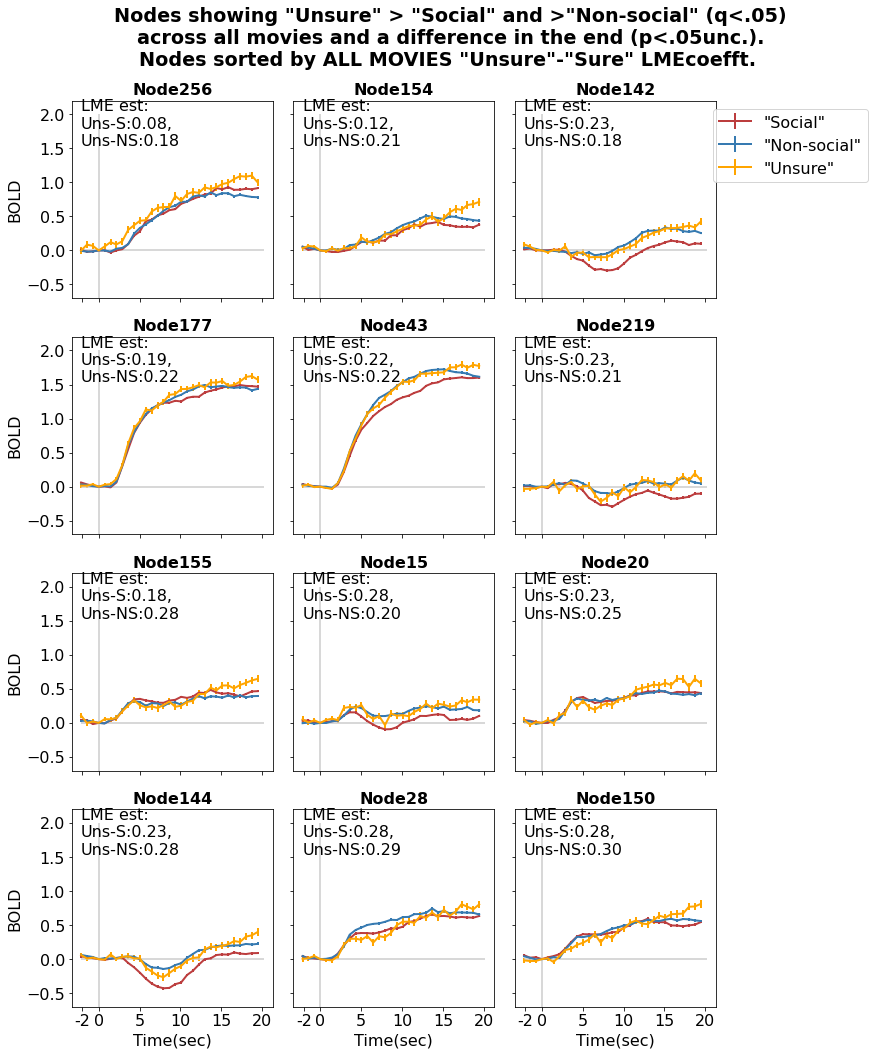

In [255]:
rand = 0 # CHANGE WHAT TO PLOT HERE!! 1: RAND, 0: ALL MOVIES


[ymin,ymax] = [-.7,2.2]
xlbls = [-2,0,5,10,15,20]
x_ticks = [(i/TR)+tr0_ind for i in xlbls]
xlbls = [str(i) for i in xlbls]

nodes = np.where(all_nodes_unsure_greaterthan_sure_conj_endcrit)[0] # rand_nodes_insig)[0]
mag_avg = np.nanmean(np.array([coef_unsure_soc_all,coef_unsure_nonsoc_all]),axis=0)
nodes = nodes[np.argsort(mag_avg[nodes])]#(-coef_unsure_sure[nodes])]
if len(nodes) < 10:
     nrows = 2
else:
     nrows = 4
ncols = int(np.ceil(len(nodes)/nrows))
#line_loc = []
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex=True, sharey=True, figsize = (12,15)) # figsize = (20,15))
if rand:
     plt.suptitle('RANDOM MECH tcs for nodes showing "Unsure" > "Sure" in the ALL MOVIES analysis (q<.05)\nsorted by ALL MOVIES "Unsure"-"Sure" LMEcoefft.', fontweight='bold')    
else:
     plt.suptitle('Nodes showing "Unsure" > "Social" and >"Non-social" (q<.05)\nacross all movies and a difference in the end (p<.05unc.).\nNodes sorted by ALL MOVIES "Unsure"-"Sure" LMEcoefft. ', fontweight='bold')    


for i,n in enumerate(nodes): #for i,n in enumerate(df['Nodes']):
     #fig, ax = plt.figure(i+1,figsize=(10,5))   
     
     if ncols == 1:
          ax1 = ax[i]
     else:
          r = int(np.floor(i/ncols))
          c = int(i % ncols)
          ax1 = ax[r,c]

     if rand:
          movieTC_yes = tcs_run_z[responses[:,4]==1,n,:,4] # nsubs * ntimepts
          movieTC_no  = tcs_run_z[responses[:,4]==0,n,:,4] # nsubs * ntimepts
          movieTC_unsure = tcs_run_z[responses[:,4]==9,n,:,4] # nsubs * ntimepts
          #movie_yes_or_no = tcs_run_z[(responses[:,4]==1)|(responses[:,4]==0),n,:,4]
     else:
          movieTC_yes = tcs_run_resh_yes[:,n,:]
          movieTC_no  = tcs_run_resh_no[:,n,:]
          movieTC_unsure  = tcs_run_resh_unsure[:,n,:] 
     
     #  
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmedian(movieTC_yes,axis=0),stats.sem(movieTC_yes,axis=0,nan_policy='omit'),color = red_rgb,linewidth=2,label ='"Social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmedian(movieTC_no,axis=0),stats.sem(movieTC_no,axis=0,nan_policy='omit'),color = blue_rgb,linewidth=2,label ='"Non-social"')
     #ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmedian(movie_yes_or_no,axis=0),stats.sem(movie_yes_or_no,axis=0,nan_policy='omit'),color = 'k',linewidth=2,label ='"Social"/"Non-social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmedian(movieTC_unsure,axis=0),stats.sem(movieTC_unsure,axis=0,nan_policy='omit'),color = 'orange',linewidth=2,label ='"Unsure"')
     ax1.vlines(tr0_ind,-1,2,color=[.8,.8,.8])
     ax1.hlines(0,0,31,color=[.8,.8,.8])
     ax1.set_ylim(ymin,ymax)
     ax1.text(0,.7*ymax,f'LME est:\nUns-S:{coef_unsure_soc_all[n]:.2f},\nUns-NS:{coef_unsure_nonsoc_all[n]:.2f}')
     if rand:
          ax1.set_title(f'Node{n+1},\nmeanUns-\nmeanSu={meanDiff_sl_rand_unsure_sure[n]:.2f}',fontweight = 'bold')          
     else:
          ax1.set_title(f'Node{n+1}',fontweight = 'bold')

     ax1.set_xticks(x_ticks)
     ax1.set_xticklabels(xlbls)
     #ax[r,0].set_ylabel('BOLD\n(a.u.)')
     #txt = '\n'.join(eval(shen268_lbl[str(n+1)][0])['name'].split(';'))
     #ax1.text(35,0,txt)
     if i %ncols==0:
          ax1.set_ylabel('BOLD')# activity (run-nomralized)')
     if r == nrows-1:
          ax1.set_xlabel('Time(sec)')
     if (r==0) & (c==ncols-1):
          ax1.legend(bbox_to_anchor = [1.8,1])

if ncols > 1:
     for i in range(int(nrows*ncols-len(nodes))):
          ax[r,c+1+i].axis('off')
plt.tight_layout()

In [256]:
nodes = np.where(all_nodes_unsure_greaterthan_sure_conj_endcrit)[0]
nodes = nodes[np.argsort(-coef_unsure_sure[nodes])]

rois = [eval(shen268_lbl[str(n+1)][0])['name'] for n in nodes]

for i,n in enumerate(nodes):
    print(n+1,rois[i])
print(f'{len(rois)} ROIs sig. at p-value threshold .05\n')

150 59.27% Paracingulate_Gyrus; 30.42% Superior_Frontal_Gyrus; 6.82% Juxtapositional_Lobule_Cortex_(formerly_Supplementary_Motor_Cortex)
28 41.56% Paracingulate_Gyrus; 27.43% Superior_Frontal_Gyrus; 21.52% Juxtapositional_Lobule_Cortex_(formerly_Supplementary_Motor_Cortex); 9.49% Cingulate_Gyrus_anterior_division
144 100.00% Frontal_Pole
15 58.36% Cingulate_Gyrus_anterior_division; 41.00% Paracingulate_Gyrus
20 43.55% Frontal_Operculum_Cortex; 33.40% Insular_Cortex; 10.36% Inferior_Frontal_Gyrus_pars_triangularis; 6.98% Frontal_Orbital_Cortex; 5.71% Inferior_Frontal_Gyrus_pars_opercularis
155 41.28% Frontal_Operculum_Cortex; 40.39% Insular_Cortex; 12.28% Frontal_Orbital_Cortex; 5.69% Inferior_Frontal_Gyrus_pars_triangularis
219 63.37% Paracingulate_Gyrus; 30.73% Cingulate_Gyrus_anterior_division; 5.90% Superior_Frontal_Gyrus
43 65.82% Lateral_Occipital_Cortex_superior_division; 19.42% Superior_Parietal_Lobule; 11.12% Angular_Gyrus
142 100.00% Frontal_Pole
177 68.85% Lateral_Occipital_C

'vmin,vmax = min(meanDiff_sl_rand_unsure_sure),max(meanDiff_sl_rand_unsure_sure)\nprint(vmin,vmax)\nvmax = .26\n\nnodes = np.zeros((268,))\n#nodes[all_nodes_unsure_greaterthan_sure] = coef_unsure_sure[all_nodes_unsure_greaterthan_sure]\nnodes[rand_nodes_unsure_greaterthan_sure] = meanDiff_sl_rand_unsure_sure[rand_nodes_unsure_greaterthan_sure]\nimg = roi_to_brain(pd.Series(nodes), mask_x)\n\n\ntxt = r"$\\overline{\x08eta}(\'\'Unsure\'\')-$" +\'\n\'+ r"$\\overline{\x08eta}(\'\'Social\'\',\'\'Non-social\'\')$"\n#txt = \'RANDOM MECH [\' + r\'$\\overline{\x08eta}_{social}-\\overline{\x08eta}_{nonsocial}$\' + \']\'\n#img.plot(colorbar=True, title = txt,cmap = \'RdBu_r\',symmetric_cbar = False)\nglassb = plot_glass_brain(img.to_nifti(), symmetric_cbar = True, title = \'RANDOM MECH\',\n                display_mode=\'lyrz\', plot_abs=False, black_bg=False,cmap = \'RdBu_r\',colorbar = True,vmax=vmax)\nglassb.title("RANDOM MECH",fontsize=24,bgcolor=\'k\',color=\'w\',fontweight=\'bold\')\nglassb.

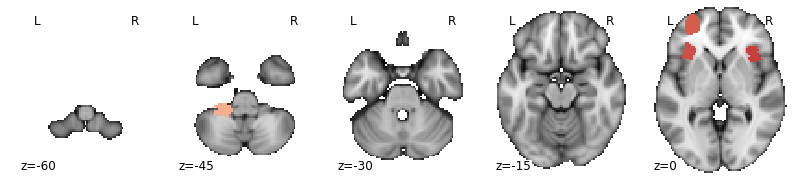

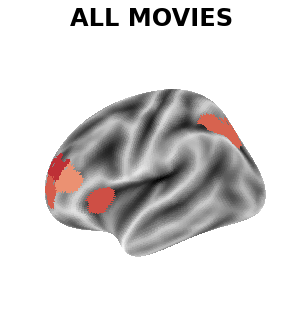

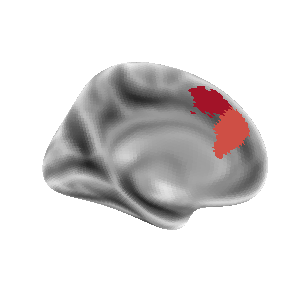

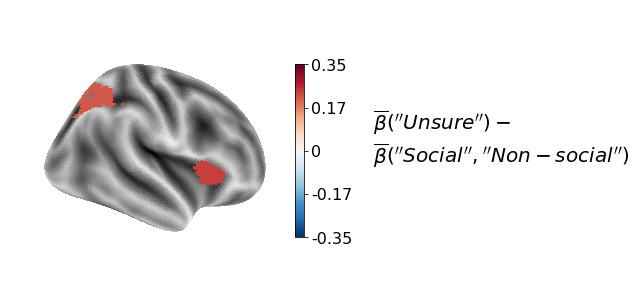

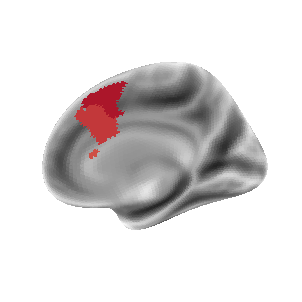

In [257]:
# surface plots
vmin,vmax = -.35,.35
cmap = 'RdBu_r'
#txt = r' $\overline{\beta}(\""")-$' + '\n' + r'$\overline{\beta}_{Non-social}$'+ '\n'
title_txt = 'ALL MOVIES'
txt = '  'r"$\overline{\beta}{(''Unsure'')}-$" + '\n  ' + r"$\overline{\beta}{(''Social'',''Non-social'')}$"
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)

nodes = np.zeros((268,))
#nodes[pval_slope_rand_unc] = meanDiff_sl_rand[pval_slope_rand_unc]
#nodes[nodes_rand_SUNS_UNSNS_unc] = meanDiff_sl_rand_S_UNS[nodes_rand_SUNS_UNSNS_unc]
nodes[all_nodes_unsure_greaterthan_sure_conj_endcrit] = coef_unsure_sure[all_nodes_unsure_greaterthan_sure_conj_endcrit]# nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)

img = roi_to_brain(pd.Series(nodes), mask_x)
#coords = [-50,-40,-30,-20,-10,0,10,25,40,50,60] # initial exploration
coords = [-60,-45,-30,-15,0] # initial exploration
ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
#ax_plot.title(title_txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
#ax_plot._colorbar_ax.text(1,.8*vmax,txt,fontsize=20,fontdict = {'verticalalignment':'top','rotation':0})#get_legend()
#ax_plot.add_contours(color_rois(common_nodes_soc_uns_nonsoc),linewidths=1, colors=['k'],linestyles ='-',filled=False)
plt.savefig(os.path.join(fig_save_loc,f'ALL_MOVIES/UnsSure_axial_conj_endcrit.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

#LH
texture = vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                            bg_map=fsaverage.sulc_left)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
#surf_plot1.axes[1].text(4,.8*vmax,s= txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
surf_plot1.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
#texture_contour = vol_to_surf(color_rois(common_nodes_soc_uns_nonsoc), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
#plot_surf_contours(fsaverage.infl_left, texture_contour, figure=surf_plot1, legend=True,levels = [1], colors=['k'])
plt.savefig(os.path.join(fig_save_loc,f'ALL_MOVIES/UnsSure_surf_left_lat_conj_endcrit.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                            bg_map=fsaverage.sulc_left, view = 'medial')#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
#surf_plot2.axes[1].text(4,.8*vmax,s= txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
#surf_plot2.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
#plot_surf_contours(fsaverage.infl_left, texture_contour, figure=surf_plot2, legend=True,levels = [1], colors=['k'])
plt.savefig(os.path.join(fig_save_loc,f'ALL_MOVIES/UnsSure_surf_left_med_conj_endcrit.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

#RH
texture = vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                            bg_map=fsaverage.sulc_right)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
#surf_plot3.axes[1].text(4,.8*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
#surf_plot3.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
#texture_contour = vol_to_surf(color_rois(common_nodes_soc_uns_nonsoc), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
#plot_surf_contours(fsaverage.infl_right, texture_contour, figure=surf_plot3, legend=True,levels = [1], colors=['k'])
surf_plot3.axes[1].text(5,.5*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
plt.savefig(os.path.join(fig_save_loc,f'ALL_MOVIES/UnsSure_surf_right_lat_conj_endcrit.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                            bg_map=fsaverage.sulc_right, view ='medial')#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
#surf_plot4.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
#plot_surf_contours(fsaverage.infl_right, texture_contour, figure=surf_plot4, legend=True, levels = [1], colors=['k'])#, labels=['Sig. (q<.05) across\n(a),(c),(d)'])
plt.savefig(os.path.join(fig_save_loc,f'ALL_MOVIES/UnsSure_surf_right_med_conj_endcrit.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')


'''vmin,vmax = min(meanDiff_sl_rand_unsure_sure),max(meanDiff_sl_rand_unsure_sure)
print(vmin,vmax)
vmax = .26

nodes = np.zeros((268,))
#nodes[all_nodes_unsure_greaterthan_sure] = coef_unsure_sure[all_nodes_unsure_greaterthan_sure]
nodes[rand_nodes_unsure_greaterthan_sure] = meanDiff_sl_rand_unsure_sure[rand_nodes_unsure_greaterthan_sure]
img = roi_to_brain(pd.Series(nodes), mask_x)


txt = r"$\overline{\beta}(''Unsure'')-$" +'\n'+ r"$\overline{\beta}(''Social'',''Non-social'')$"
#txt = 'RANDOM MECH [' + r'$\overline{\beta}_{social}-\overline{\beta}_{nonsocial}$' + ']'
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
glassb = plot_glass_brain(img.to_nifti(), symmetric_cbar = True, title = 'RANDOM MECH',
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True,vmax=vmax)
glassb.title("RANDOM MECH",fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.05,txt,fontsize=24,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
#glassb.add_contours(color_rois(rand_nodes_unsure_greaterthan_sure),linewidths=lw[1], colors=[cols[1]],linestyles='dotted')
glassb.add_contours(color_rois(common_nodes),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'rand/unsure_v_sure.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

nodes = np.zeros((268,))
#nodes[rand_nodes_unsure_greaterthan_sure] = meanDiff_sl_rand_unsure_sure[rand_nodes_unsure_greaterthan_sure]
nodes[common_nodes] = meanDiff_sl_rand_unsure_sure[common_nodes]
img = roi_to_brain(pd.Series(nodes), mask_x)
#plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
#                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
ax_plot = plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=coords, vmax = vmax,cmap = 'RdBu_r',colorbar=False,annotate=True)
#ax_plot.title("RANDOM MECH",fontsize=24,bgcolor='k',color='w',fontweight='bold')
plt.savefig(os.path.join(fig_save_loc,'rand/unsure_v_sure_axial.png'),dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')'''



-0.34809065043255083 0.29865647724689826


<Figure size 720x216 with 0 Axes>

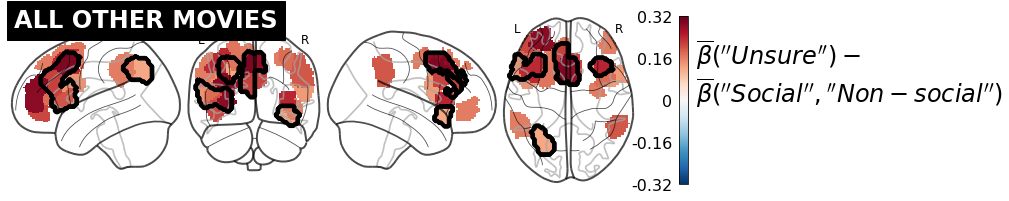

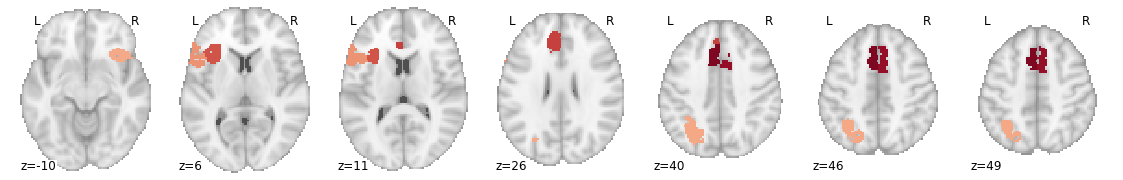

In [102]:

vmin,vmax = min(coef_unsure_sure),max(coef_unsure_sure)
print(vmin,vmax)
vmax = .32

nodes = np.zeros((268,))
#nodes[all_nodes_unsure_greaterthan_sure] = coef_unsure_sure[all_nodes_unsure_greaterthan_sure]
nodes[all_nodes_unsure_greaterthan_sure] = coef_unsure_sure[all_nodes_unsure_greaterthan_sure]
img = roi_to_brain(pd.Series(nodes), mask_x)

fig=plt.figure(1,figsize=((10,3)))
txt = r"$\overline{\beta}(''Unsure'')-$" + '\n' + r"$\overline{\beta}(''Social'',''Non-social'')$"
glassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = True, title='ALL MOVIES', alpha=0.7, vmin=vmin,vmax= vmax, 
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb.title("ALL OTHER MOVIES",fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.1,txt,fontsize=24,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb.add_contours(color_rois(all_nodes_unsure_greaterthan_sure),linewidths=lw[1], colors=[cols[1]],linestyles='dotted')
glassb.add_contours(color_rois(common_nodes),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'all_movies/unsure_v_sure.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

nodes = np.zeros((268,))
#nodes[all_nodes_unsure_greaterthan_sure] = coef_unsure_sure[all_nodes_unsure_greaterthan_sure]
nodes[common_nodes] = coef_unsure_sure[common_nodes]
img = roi_to_brain(pd.Series(nodes), mask_x)
#plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
#                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
ax_plot = plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=coords, cmap = 'RdBu_r',vmax=vmax,colorbar=False,annotate=True)
#ax_plot.title("ALL OTHER MOVIES",fontsize=24,bgcolor='k',color='w',fontweight='bold')
plt.savefig(os.path.join(fig_save_loc,'all_movies/unsure_v_sure_axial.png'),dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')



In [116]:
fig_save_loc

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/unsure_analyses/'

In [118]:
print(min(meanDiff_sl_rand_unsure_sure),max(meanDiff_sl_rand_unsure_sure))
print(min(coef_unsure_sure),max(coef_unsure_sure))

-0.2556920696778834 0.20894016749339722
-0.34809065043255083 0.29865647724689826


 
0.5821 x - 0.02227


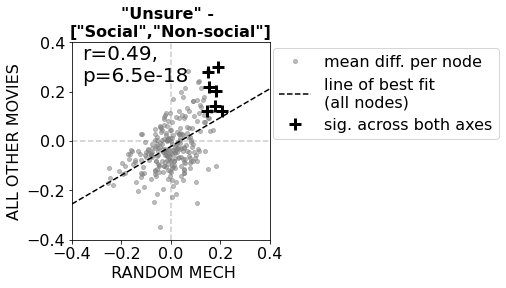

In [34]:
dims = [10,8]
fig= plt.figure(1,figsize = dims)

xymin,xymax = -.4,.4
ax = fig.add_subplot(221) #meanDiff_sl_rand_unsure_sure[rand_nodes_unsure_greaterthan_surea]
X,Y = meanDiff_sl_rand_unsure_sure,coef_unsure_sure
plot_fig(X,Y,' RANDOM MECH','ALL OTHER MOVIES',xymin,xymax)
ax.set_aspect('equal')
#signodes
plot_sig_nodes(X,Y,common_nodes)
#plt.plot(X[nodes_all_SUNS_UNSNS],Y[nodes_all_SUNS_UNSNS],mec='k',marker='o',mfc='none',ls='None')
plt.title('"Unsure" - \n["Social","Non-social"]',fontweight ='bold')
plt.legend(bbox_to_anchor = (2.2,1.01),fontsize =16)
plt.savefig(os.path.join(fig_save_loc,'rand_v_all_scatterplots.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')



# extra code

In [ ]:
from multipy.fdr import lsu
#from multipy.data import neuhaus

significant_pvals = lsu(np.array(x), q=0.01)
#print(zip(['{:.4f}'.format(p) for p in x], significant_pvals))
significant_pvals

In [ ]:
nodes = np.zeros((268,))
nodes[pval_slope_coaxbill] = meanDiff_sl_coaxbill[pval_slope_coaxbill]
img = roi_to_brain(pd.Series(nodes), mask_x)
plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)


img = roi_to_brain(pd.Series(meanDiff_sl_coaxbill), mask_x)
#txt = 'COAX-BILL [' + r'$\overline{\beta_{social}-{\beta}_{nonsocial}}$' + ']'
txt = r'$\overline{\beta_{social}-{\beta}_{nonsocial}}$'
#txt = f"COAXBILL"
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
glassb = plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb.add_contours(color_rois(pval_slope_coaxbill),linewidths=lw[1], colors=[cols[1]],linestyle='dashed')
glassb.add_contours(color_rois(nodes_coaxbill_rand_all),linewidths=lw[0], colors=[cols[0]],linestyle='dashed')
#glassb.add_contours(color_rois(nodes_coaxbill_rand_all_fish),linewidths=lw[2], colors=[cols[2]],filled=True,linestyle='dashed')



In [ ]:
### fish
# same movie: fish

movie_ind = 3

soc_inds = responses[:,movie_ind]==1 # subs who responded "social"
nonsoc_inds = responses[:,movie_ind]==0 # subs who respoded "nonsocial"

print(f'movie={vid_joined[movie_ind]},soc={len(np.where(soc_inds)[0])},nonsocial={len(np.where(nonsoc_inds)[0])}')

# ttest between slope regs yes vs. no
_,pval_slope_fish = stats.ttest_ind(coef_slope_fish[soc_inds,:], coef_slope_fish[nonsoc_inds,:],axis=0, equal_var=False)
meanDiff_sl_fish = np.nanmean(coef_slope_fish[soc_inds,:],axis=0)-np.nanmean(coef_slope_fish[nonsoc_inds,:],axis=0)

#fdr correction
#_,pval_slope_fish = fdr_correction(pval_slope_fish,.05)
pval_slope_fish = lsu(pval_slope_fish,q=.05)

dirn_fish = np.empty((268,))
count=0
for n in range(268):
    if np.abs(np.nanmean(coef_slope_fish[soc_inds,n],axis=0)) > np.abs(np.nanmean(coef_slope_fish[nonsoc_inds,n],axis=0)):
        dirn_fish[n] = 1
    elif np.abs(np.nanmean(coef_slope_fish[soc_inds,n],axis=0)) < np.abs(np.nanmean(coef_slope_fish[nonsoc_inds,n],axis=0)):
        dirn_fish[n] = -1
    else:
        dirn_fish[n] = 0

In [ ]:
## all movies t-tests (doesn't consider shared variance between subs - but good to get an initial impression)

coef_trial_resh_yes = []
coef_trial_resh_unsure = []
coef_trial_resh_no = []

for m in range(10):
    fileName =  os.path.join(data_file_loc,f'coef_slopereg_trialnorm_{vidnames[m]}.npy')
    coefs_ = np.load(fileName)
    #print(dat.shape)
    coef_trial_resh_yes.append(coefs_[responses[:,m]==1,:])# subsm * 268 * nt0
    coef_trial_resh_no.append(coefs_[responses[:,m]==0,:])# subsm * 268 * nt1
    coef_trial_resh_unsure.append(coefs_[responses[:,m]==9,:])# subsm * 268 * nt2

coef_trial_resh_yes = np.concatenate(coef_trial_resh_yes,axis=0)
coef_trial_resh_no = np.concatenate(coef_trial_resh_no,axis=0)
coef_trial_resh_unsure = np.concatenate(coef_trial_resh_unsure,axis=0)
print('Across movies: \n\tyes:'+ str(coef_trial_resh_yes.shape) + ',no:' + str(coef_trial_resh_no.shape)+ ',unsure:' + str(coef_trial_resh_unsure.shape))


# ttest between slope regs yes vs. no
_,pval_slope_all_S_NS = stats.ttest_ind(coef_trial_resh_yes, coef_trial_resh_no, axis=0, equal_var=False)
pval_slope_all_S_NS = lsu(pval_slope_all_S_NS,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_all_S_NS = np.nanmean(coef_trial_resh_yes,axis=0)-np.nanmean(coef_trial_resh_no,axis=0)

# ttest between slope regs yes vs. unsure
_,pval_slope_all_S_UNS = stats.ttest_ind(coef_trial_resh_yes, coef_trial_resh_unsure, axis=0, equal_var=False)
pval_slope_all_S_UNS = lsu(pval_slope_all_S_UNS,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_all_S_UNS = np.nanmean(coef_trial_resh_yes,axis=0)-np.nanmean(coef_trial_resh_unsure,axis=0)

# ttest between slope regs unsure vs. no
_,pval_slope_all_UNS_NS_unc = stats.ttest_ind(coef_trial_resh_unsure, coef_trial_resh_no,axis=0, equal_var=False)
pval_slope_all_UNS_NS = lsu(pval_slope_all_UNS_NS_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_all_UNS_NS = np.nanmean(coef_trial_resh_unsure,axis=0)-np.nanmean(coef_trial_resh_no,axis=0)

#pval_slope_all_UNS_NS_unc = pval_slope_all_UNS_NS_unc<.05


_,pval_slope_all_unsure_sure = stats.ttest_ind(coef_trial_resh_unsure,np.concatenate((coef_trial_resh_yes,coef_trial_resh_no)), axis=0, equal_var=False)
pval_slope_all_unsure_sure = lsu(pval_slope_all_unsure_sure,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_all_unsure_sure = np.nanmean(coef_trial_resh_unsure,axis=0)-np.nanmean(np.concatenate((coef_trial_resh_yes,coef_trial_resh_no)),axis=0)


In [ ]:
# social>unsure and unsure>non-social or vice-versa
nodes_all_SUNS_UNSNS = (pval_slope_all_S_UNS) & (pval_slope_all_UNS_NS) & (np.sign(meanDiff_sl_all_S_UNS) == np.sign(meanDiff_sl_all_UNS_NS)) 
len(np.where(nodes_all_SUNS_UNSNS)[0])


print('All movies: S v Unsure:',min(meanDiff_sl_all_S_UNS),max(meanDiff_sl_all_S_UNS))
print('All movies: Unsure v BS:',min(meanDiff_sl_all_UNS_NS),max(meanDiff_sl_all_UNS_NS))


In [ ]:
nodes = np.zeros((268,))
nodes[pval_slope_all_S_UNS] = meanDiff_sl_all_S_UNS[pval_slope_all_S_UNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
plot_glass_brain(img.to_nifti(),symmetric_cbar = True, vmin=vmin,vmax= vmax,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)

nodes = np.zeros((268,))
nodes[pval_slope_all_UNS_NS] = meanDiff_sl_all_UNS_NS[pval_slope_all_UNS_NS]
img = roi_to_brain(pd.Series(nodes), mask_x)
plot_glass_brain(img.to_nifti(),symmetric_cbar = True, vmin=vmin,vmax=vmax,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)


In [ ]:
fig=plt.figure(1,figsize=((10,3)))
txt = r"$\overline{\beta}(''Social'')-$" + '\n' + r"$\overline{\beta}(''Unsure'')$"
#txt = 'RANDOM MECH [' + r'$\overline{\beta}_{social}-\overline{\beta}_{nonsocial}$' + ']'
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
img = roi_to_brain(pd.Series(meanDiff_sl_all_S_UNS), mask_x)
glassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = True, title='ALL MOVIES', alpha=0.7, vmin=vmin,vmax= vmax, 
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb.title("ALL MOVIES",fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.1,txt,fontsize=20,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb._colorbar_ax.set_title(txt,fontsize=20)#get_legend()
#glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
#glassb.add_contours(color_rois(pval_slope_all_S_UNS),linewidths=lw[1], colors=[cols[1]],linestyles='dotted')
glassb.add_contours(color_rois(nodes_all_SUNS_UNSNS),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'all_movies/social_v_unsure.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

fig=plt.figure(2,figsize=((10,3)))
nodes = np.zeros((268,))
nodes[nodes_all_SUNS_UNSNS] = meanDiff_sl_all_S_UNS[nodes_all_SUNS_UNSNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
output_file = os.path.join(fig_save_loc,'all_movies/social_v_unsure_axial.png')
plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=10*np.arange(-4,6,2), cmap = 'RdBu_r',vmax=vmax,colorbar=False,annotate=True)
plt.savefig(output_file,dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')



fig=plt.figure(3,figsize=((10,3)))
txt = r"$\overline{\beta}(''Unsure'')-$" + '\n' + r"$\overline{\beta}(''Non-social'')$"
#txt = 'RANDOM MECH [' + r'$\overline{\beta}_{social}-\overline{\beta}_{nonsocial}$' + ']'
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
img = roi_to_brain(pd.Series(meanDiff_sl_all_UNS_NS), mask_x)
glassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = True, title='ALL MOVIES', vmin=vmin,vmax= vmax,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb.title("ALL MOVIES",fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.1,txt,fontsize=20,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb._colorbar_ax.set_title(txt,fontsize=20)#get_legend()
#glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
#glassb.add_contours(color_rois(pval_slope_all_UNS_NS),linewidths=lw[1], colors=[cols[1]],linestyles='dotted')
glassb.add_contours(color_rois(nodes_all_SUNS_UNSNS),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'all_movies/unsure_v_nonsocial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

fig=plt.figure(4,figsize=((10,3)))
nodes = np.zeros((268,))
nodes[nodes_all_SUNS_UNSNS] = meanDiff_sl_all_UNS_NS[nodes_all_SUNS_UNSNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
output_file = os.path.join(fig_save_loc,'all_movies/unsure_v_nonsocial_axial.png')
plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=10*np.arange(-4,6,2), cmap = 'RdBu_r',vmax=vmax,colorbar=False,annotate=True)
plt.savefig(output_file,dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')




In [ ]:
nodes_all_UNS_SURE= (pval_slope_all_S_NS) & (pval_slope_all_UNS_NS) &(~pval_slope_all_S_NS) & (np.sign(meanDiff_sl_all_S_UNS) == -1) & (np.sign(meanDiff_sl_all_UNS_NS)==1) 
len(np.where(nodes_all_UNS_SURE)[0])

# social>nonsocial and social>unsure or vice-versas

In [ ]:

fig = plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True,vmin=-.22,vmax=.55)
#fig._show_colorbar(plt.get_cmap('RdBu_r'), MidpointNormalize(midpoint=0., vmin=cmin, vmax=cmax))
#box = fig._colorbar_ax.get_position()
#total_cols=5
#fig._colorbar_ax.set_p9osition([box.x0+(box.x0*0.1/total_cols), box.y0, box.width, box.height])  # move a bit the bar to the right, need to divide by number of columns (to move relative to last figure only, not to overall row, else will get too far away)
#fig._colorbar_ax.set_label('xxxxxxxxxxxx')
fig._colorbar_ax.set_title('xx')#get_legend()
fig._colorbar_ax.set_xticklabels({-1:'-1',0:'0',1:'1'})#get_legend()

ax = plt.gcf().axes[5].axis() #plt.gcf().axes[i].set_label('abc'+str(i))# rmatter(ticker.FormatStrFormatter("%i")))
plt.gcf().axes[5].axis()


In [ ]:
# looks weird.. so sanity checks

nodes = np.zeros((268,))
nodes[nodes_all_SUNS_UNSNS] = meanDiff_sl_all_S_UNS[nodes_all_SUNS_UNSNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)

nodes = np.zeros((268,))
nodes[nodes_all_SUNS_UNSNS] = meanDiff_sl_all_UNS_NS[nodes_all_SUNS_UNSNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)


In [ ]:
nodes=  np.zeros((268,))
nodes[pval_slope_all_unsure_sure] = meanDiff_sl_all_unsure_sure[pval_slope_all_unsure_sure]
img = roi_to_brain(pd.Series(nodes), mask_x)
img.plot(colorbar=True,cmap = 'RdBu_r',title='ALL MOVIES', symmetric_cbar = False)


txt = r'$\overline{\beta}_{unsure}-\overline{\beta}_{social,nonsocial}$'
#txt = 'RANDOM MECH [' + r'$\overline{\beta}_{social}-\overline{\beta}_{nonsocial}$' + ']'
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
img = roi_to_brain(pd.Series(meanDiff_sl_all_unsure_sure), mask_x)
glassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = False, title='ALL MOVIES', 
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb._colorbar_ax.set_title(txt,fontsize=20)#get_legend()
#glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
#glassb.add_contours(color_rois(pval_slope_all_S_UNS),linewidths=lw[1], colors=[cols[1]],linestyles='dotted')
glassb.add_contours(color_rois(pval_slope_all_unsure_sure),linewidths=lw[0], colors=[cols[0]],linestyles='solid')




plt.hist(meanDiff_sl_all_unsure_sure,bins=20,color='grey')
plt.xlabel(r'$\overline{\beta}_{unsure}>\overline{\beta}_{social,nonsocial}$')
plt.ylabel('Number of nodes')
ymin,ymax=plt.ylim()
plt.vlines(np.nanmean(meanDiff_sl_all_unsure_sure),ymin,ymax,color='k',label='Mean')
plt.legend()
plt.title('ALL MOVIES')

In [ ]:
plt.hist(meanDiff_sl_rand_unsure_sure,bins=20,color='grey')
plt.xlabel(r'$\overline{\beta}_{unsure}>\overline{\beta}_{social,nonsocial}$')
plt.ylabel('Number of nodes')
ymin,ymax=plt.ylim()
plt.vlines(np.nanmean(meanDiff_sl_rand_unsure_sure),ymin,ymax,color='k',label='Mean')
plt.legend()
plt.title('RANDOM MECH')

# extra 

In [ ]:

txt = r"$\overline{\beta}(''Social'')-$" + '\n' + r"$\overline{\beta}(''Non-social'')$"
#txt = 'RANDOM MECH [' + r'$\overline{\beta}_{social}-\overline{\beta}_{nonsocial}$' + ']'
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
img = roi_to_brain(pd.Series(meanDiff_sl_rand_S_NS), mask_x)
fig=plt.figure(2,figsize=((10,3)))
glassb = plot_glass_brain(img.to_nifti(), symmetric_cbar = True,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True,vmax=vmax)
#glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb.title("RANDOM MECH",fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.2,txt,fontsize=20,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb._colorbar_ax.set_title(txt,fontsize=20)#get_legend()
#glassb._colorbar_ax.set_position([0.999,0.01,.05,.95])
#glassb._colorbar_ax.orientation = 'vertical'#glassb._colorbar_ax.set_snap]
#glassb._colorbar_margin['top'] = .1
glassb.add_contours(color_rois(pval_slope_rand_S_NS),linewidths=lw[1], colors=[cols[1]],linestyles='dotted') #this contrast
glassb.add_contours(color_rois(nodes_rand_SNS_SUNS),linewidths=lw[0], colors=[cols[0]],linestyles='solid') # all contrasts
plt.savefig(os.path.join(fig_save_loc,'rand/soc_v_nonsoc.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

nodes = np.zeros((268,))
nodes[pval_slope_rand_S_NS] = meanDiff_sl_rand_S_NS[pval_slope_rand_S_NS]
img = roi_to_brain(pd.Series(nodes), mask_x)
#plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
#                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
ax_plot = plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=10*np.arange(-4,7,2), vmax = vmax,cmap = 'RdBu_r',colorbar=True,annotate=True)
ax_plot.title('S>NS,p<.05corr',fontsize=24,bgcolor='k',color='w',fontweight='bold')

#ax_plot.title("RANDOM MECH",fontsize=24,bgcolor='k',color='w',fontweight='bold')
plt.savefig(os.path.join(fig_save_loc,'rand/soc_v_nonsoc_axial.png'),dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')


In [ ]:
#### social>(NS and unsure) or vice-versa
# # social>nonsocial and social>unsure or vice-versa
#nodes_rand_SNS_SUNS = (pval_slope_rand_S_NS) & (pval_slope_rand_S_UNS) & (np.sign(meanDiff_sl_rand_S_NS) == np.sign(meanDiff_sl_rand_S_UNS)) 
#print('nodes_rand_SNS_SUNS:',len(np.where(nodes_rand_SNS_SUNS)[0]))
